# X-Plane 11 Aircraft Taxi Controller using Images

The time has finally come to put it together and show off all your hard work!

In this notebook, you use the network you just trained to implement an image-based controller for the aircraft taxi problem and observe it in action! This notebook will be very similar to TaxiController notebook expect now we will not give our controller access to the true state. Instead, it will only have access to the camera images from the front of the aircraft represented by our screenshots.

First, let's import some of the python packages we will need:

In [66]:
import time
import numpy as np
import os

import mss
import cv2
from PIL import Image

from xpc3 import *
from xpc3_helper import *
from plotting_helper import *

import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

import imageio

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

Next, we need to get X-Plane 11 ready to go. We will follow the same steps as we did in the X-Plane 11 tutorial notebook:

1. **Open X-Plane 11.** Look for the X-Plane 11 icon in the dock at the bottom of your screen (it should be towards the right). Click this icon and X-Plane 11 will open. A window may pop up saying that there is an update available. If this happens, you can just click "ignore".
2. From the main menu of X-Plane 11, click "New Flight". This should bring up a window with some flight configuration options.
3. In the AIRCRAFT section, select the Cessna Skyhawk.
4. In the location section, select Grant Co Intl (ID is KMWH).
5. You can leave the weather as clear.
6. In the TIME OF DAY section, select a time between 8AM and 10AM local.
7. Click the "Start Flight" button at the bottom right of the screen. It make take a minute or so to load the flight. Once it loads, you should see the front of the aircraft pointing down a runway. We are now ready to start controlling it!

To set up X-Plane in the configuration we need to capture images, we need to follow a few extra steps:

1. **Click the settings button**. The button should be on the top right of the screen next to the question mark and looks like an icon with three dials. It should bring up a settings window.
2. **Go to the Graphics tab**. The Graphics tab should be third from the left at the top of the settings window.
3. **Put in full screen mode**. In the "Monitor Configuration" section of the Graphics tab, make sure to select full screen simulator under monitor usage.
4. **Set the screen resolution**. For resolution, select 1440x900. If this is not an option, you can select "custom" and manually set it to this.
5. **Close the settings window**. Click done in the bottom right corner.
6. **Change the view**. Under view in the top left corner of the screen, from the "Change (Internal)" menu, select "Forward with No Display".

Connect to X-Plane 11 by creating a client that we can use to interface with the simulator:

In [67]:
client = XPlaneConnect()
reset(client)

The function below is the solution to the `getCurrentImage` function that we implemented in the data generation notebook. It takes care of grabbing the screenshot and creating the downsampled image for us.

In [68]:
def getCurrentImage(screenShot):
    """ Returns both the current image (direct screenshot) and 
        processed 128-pixel image
        Args:
            screenShot: mss screenshot object
    """
    # Get the screenshot
    ss = cv2.cvtColor(np.array(screenShot.grab(screenShot.monitors[0])), cv2.COLOR_BGRA2BGR)[:, :, ::-1]
    # Resize to 360x200
    img_resized = cv2.resize(ss, (360, 200))
    # Crop out the sky
    img_cropped = img_resized[100:, :, :]
    # Convert to grayscale
    img_grayscale = np.array(Image.fromarray(img_cropped).convert('L')) / 255.0
    # Downsample
    stride = 16
    numPix = 16
    width = 256//stride
    height = 128//stride

    # Downsample image
    # Split image into stride x stride boxes, average numPix brightest pixels in that box
    # As a result, img_ds has one value for every box
    img_grayscale_resize = cv2.resize(img_grayscale, (256, 128))
    img_ds = np.zeros((height, width))
    for i in range(height):
        for j in range(width):
            img_ds[i, j] = np.mean(np.sort(
                img_grayscale_resize[stride*i:stride*(i+1), stride*j:stride*(j+1)].reshape(-1))[-numPix:])
    # Bias to have mean of 0.5
    # Ensure that the mean of the image is 0.5 and that values range between 0 and 1
    img_ds -= img_ds.mean()
    img_ds += 0.5
    img_ds[img_ds > 1] = 1
    img_ds[img_ds < 0] = 0
    # Return the original screenshot and processed image
    return ss, img_ds

## Simulation Functions
To simulate our taxi controller, we need to implement a *closed-loop system*. We will use the same components as the to create our closed-loop system as we did before, but we will need to make a few changes to each component to use our images. At each time step, we want to:

1. Get the current state of the system
2. Determine our control input using the state (steering angle)
3. Feed the current state and control input into the dynamics function to determine the next state
4. Go back to step 1!

Like before, we will make separate functions for steps 1-3.

### 1. Get the current state
This function was pretty simple before when we knew the current state. This time, we need to get predictions for the state using the images from the aircraft and our neural network. Fill in the function below to get the predictions for the state.

**HINT:** to reshape an image, you can use `image.reshape(shape)` where `shape` is a tuple containing the desired shape

**HINT:** to get a the network prediction for a specific image, use `model.predict(img)[0]` where `img` is an image of size 1 x 128. This will return an array with the predicted crosstrack error as the first element and the predicted heading error as the second element

In [69]:
def getState(image, model):
    """ Returns the true crosstrack error (meters) and
        heading error, (degrees) to simulate fully 
        oberservable control
        Args:
            image: 8x16 grayscale preprocessed image of the runway
            model: neural network model used to predict the state as a keras model
    """
    # STUDENT CODE START
    # Reshape the image to be 1 x 128
    image_reshaped = image.reshape((1,128)) # YOUR CODE HERE!
    # Pass the image through the network to get the predictions
    preds = model.predict(image_reshaped)[0] # YOUR CODE HERE!
    # Use the predictions to return the crosstrack and heading error
    cte_pred = preds[0] # YOUR CODE HERE!
    he_pred = preds[1] # YOUR CODE HERE!
    # STUDENT CODE END
    return cte_pred, he_pred

### 2. Determine the control input

We will still use the same control function, just on our predicted state rather than the true state. Thus, you can just copy the control gains you found in the taxi controller notebook.

In [70]:
def getControl(client, cte, he):
    """ Returns steering angle command using proportional control
        Args:
            client: XPlane Client
            cte: current estimate of the crosstrack error, x (meters)
            he: current estimate of the heading error, theta (degrees)
    """
    # STUDENT CODE START
    cte_gain = -1.03 # YOUR VALUE HERE!
    he_gain = -0.56 # YOUR VALUE HERE!
    return cte_gain * cte + he_gain * he
    # STUDENT CODE END

### 3. Get the next state
We will also use the same dynamics function. We have pasted in our solution from the taxi controller notebook:

In [71]:
def dynamics(cte, dtp, he, phi_deg, dt=0.05, v=5):
    """ dynamics model (returns next state)
        Args:
            cte: current crosstrack error (meters)
            dtp: current downtrack position (meters)
            he: current heading error (degrees)
            phi_deg: steering angle input (degrees)
            -------------------------------
            dt: time step (seconds)
            v: speed (m/s)
    """

    he_rad = np.deg2rad(he)

    cte_next = cte + v * np.sin(he_rad) * dt
    dtp_next = dtp + v * np.cos(he_rad) * dt
    he_next = he + phi_deg * dt

    return cte_next, he_next, dtp_next

### Put it all together!
We can now put everything together into a single simulation function. The function follows similar steps to the simulation function used in the taxi control notebook. We have filled in this one for you with our solution. Check out the code below to see how it all works. 

The main difference between this function and the function from the taxi controller notebook is that we now need to grab screenshots call our neural network to get our state. We also keep track of a few extra variables so that we can replay our results in the end.

In [72]:
def simulate_controller(client, startCTE, startHE, startDTP, getState, getControl, model,
                               dt=0.05, ctrlEvery=20, nsteps = 400, simSpeed=1.0, screenShot = mss.mss()):
    """ Simulates a controller, overriding the built-in XPlane-11 dynamics to model the aircraft
        as a Dubin's car
        Args:
            client: XPlane Client
            startCTE: Starting crosstrack error (meters)
            startHE: Starting heading error (degrees)
            startDTP: Starting downtrack position (meters)
            getState: Function to estimate the current crosstrack and heading errors.
                      Takes in an XPlane client and returns the crosstrack and
                      heading error estimates
            getControl: Function to perform control based on the state
                        Takes in an XPlane client, the current crosstrack error estimate,
                        and the current heading error estimate and returns a control effort
            model: neural network model used to predict the state as a keras model
            -------------------
            dt: time step (seconds)
            crtlEvery: Frequency to get new control input 
                       (e.g. if dt=0.5, a value of 20 for ctrlEvery will perform control 
                       at a 1 Hz rate)
            nsteps: Number of time steps to run the simulation for
            simSpeed: increase beyond 1 to speed up simulation
            screenShot: mss screenshot object
    """
    # Reset to the desired starting position
    client.sendDREF("sim/time/sim_speed", simSpeed)
    reset(client, cteInit=startCTE,
                      heInit=startHE, dtpInit=startDTP)
    sendBrake(client, 0)

    time.sleep(5)  # 5 seconds to get terminal window out of the way

    # Initialize the crosstrack error, heading error, and downtrack position
    cte = startCTE
    he = startHE
    dtp = startDTP

    # Initialize the steering angle to 0 degrees
    phiDeg = 0.0 # degrees

    # Initialize arrays of zeros to store the results in
    cte_history = np.zeros(nsteps)
    he_history = np.zeros(nsteps)
    dtp_history = np.zeros(nsteps)

    cte_pred_history = []
    he_pred_history = []

    ss_history = []
    img_ds_history = []

    for i in range(nsteps): # Repeat for nsteps
        # Record the current cte, he, and dtp into their corresponding arrays
        cte_history[i] = cte
        he_history[i] = he
        dtp_history[i] = dtp

        # If we should change our control
        if i % ctrlEvery == 0:
            # Get the current image
            ss, img_ds = getCurrentImage(screenShot)
            ss_history.append(ss)
            img_ds_history.append(img_ds)
            # Get the current state
            cte_pred, he_pred = getState(img_ds, model)
            cte_pred_history.append(cte_pred)
            he_pred_history.append(he_pred)
            # Use the current state to get the control
            phiDeg = getControl(client, cte_pred, he_pred)

        # Update the cte, he, and dtp using the dynamics function
        cte, he, dtp = dynamics(cte, dtp, he, phiDeg, dt)
        # Set the simulator to move to the next state
        setHomeState(client, cte, dtp, he)
        # Sleep for 0.03 seconds to give the simulator time to update everything
        time.sleep(0.03)

    return cte_history, he_history, dtp_history, cte_pred_history, he_pred_history, ss_history, img_ds_history


## Test your controller!

### Specify the settings

The cell below defines some settings for the simulator such as the time of day and weather conditions. You can just leave these as is for now.

In [73]:
# Time of day in local time, e.g. 8.0 = 8AM, 17.0 = 5PM
TIME_OF_DAY = 8.0

# Cloud cover (higher numbers are cloudier/darker)
# 0 = Clear, 1 = Cirrus, 2 = Scattered, 3 = Broken, 4 = Overcast
CLOUD_COVER = 0

# Start downtrack position (322 m is a good starting place)
START_DTP = 322.0

# Set weather and time of day
client.sendDREF("sim/time/zulu_time_sec", TIME_OF_DAY * 3600 + 8 * 3600)
client.sendDREF("sim/weather/cloud_type[0]", CLOUD_COVER)

Next, we need to load in the neural network we trained to predict the state. Run the following cell to load it into a variable called `taxinet `.

In [74]:
taxinet = load_model("Taxinet.h5")

### Run a single simulation
The line below will run a single simulation and store the results in arrays some output arrays. Run this cell now to watch your controller in action! It will pause for 5 seconds before starting and then run for 20 seconds.

In [75]:
time.sleep(5)
ctes, hes, dtps, cte_preds, he_preds, sss, img_dss = simulate_controller(
    client, 6.0, 0.0, START_DTP, getState, getControl, taxinet)

1/1 [==============================] - 0s 44ms/step


### Plot the results

Sometimes, it is helpful to visualize the trajectory that the aircraft followed. We can use this to see if the aircraft is behaving how we expect it to. Also, we can use it to show others how our system performs (like in your final presentation!). The following two cells contain code for you to do this. The first cell imports some python plotting packages that you will use. The second cell plots the trajectory on the road. We have implemented a function for you to get a plot of the road in the `plotting_helper.py` file.

In [47]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches

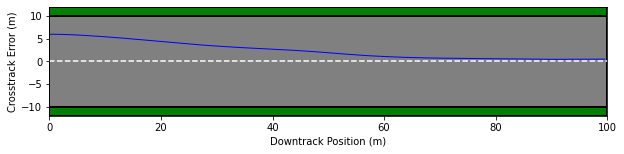

In [48]:
# Get the plot of the road
fig, ax = plot_road()
# Plot the trajectory on the road
ax.plot(dtps - START_DTP, ctes, 'b', linewidth=1)
# Add axis labels
ax.set_xlabel('Downtrack Position (m)')
ax.set_ylabel('Crosstrack Error (m)')
# Display the plot
plt.show()

### Create an animation

What is cooler than a plot of the trajectory? An animation of it!

In [53]:
def save_gif_frame(ss, img_ds, dtps, ctes, cte_preds, filename):
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(ss)
    ax1.set_title('Original Image')
    plt.axis('off')
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(img_ds, cmap='gray', clim=(0, 1))
    ax2.set_title('Downsampled Image')
    plt.axis('off')

    # Road plot
    ax3 = fig.add_subplot(gs[1, :])
    codes = [Path.MOVETO, Path.LINETO,
             Path.LINETO, Path.LINETO, Path.CLOSEPOLY]

    xmin = 0.0
    xmax = 100.0
    ymin = -12.0
    ymax = 12.0

    # Bottom grass
    verts_bottom_grass = [(xmin, ymin), (xmin, -10.0),
                          (xmax, -10.0), (xmax, ymin), (0.0, 0.0)]
    path_bottom_grass = Path(verts_bottom_grass, codes)
    patch_bottom_grass = patches.PathPatch(
        path_bottom_grass, facecolor='green', lw=2)
    ax3.add_patch(patch_bottom_grass)
    # Top grass
    verts_top_grass = [(xmin, 10.0), (xmin, ymax),
                       (xmax, ymax), (xmax, 10.0), (0.0, 0.0)]
    path_top_grass = Path(verts_top_grass, codes)
    patch_top_grass = patches.PathPatch(
        path_top_grass, facecolor='green', lw=2)
    ax3.add_patch(patch_top_grass)
    # Road
    verts_road = [(xmin, -10.0), (xmin, 10.0),
                  (xmax, 10.0), (xmax, -10.0), (0.0, 0.0)]
    path_road = Path(verts_road, codes)
    patch_road = patches.PathPatch(path_road, facecolor='gray', lw=2)
    ax3.add_patch(patch_road)

    # Centerline
    ax3.plot([xmin, xmax], [0.0, 0.0], 'w--')

    ax3.set_xlim(xmin, xmax)
    ax3.set_ylim(ymin, ymax)

    # Plot the trajectory
    ax3.plot(dtps - 322.0, ctes, 'b', lw=3)
    # print(dtps[0::5].shape)
    # print(len(cte_preds))
    ax3.plot(dtps[0::5] - 322.0, cte_preds, 'o', markersize=7, color='pink')

    ax3.set_title('Overhead View')

    fig.set_figwidth(12)
    fig.set_figheight(6)

    plt.savefig(filename)


In [54]:
def create_gif(gifname, sss, img_dss, dtps, ctes, cte_preds):
    # Create the images
    filenames = []
    j = 0
    for i in range(ctes.shape[0]):
        if i == 0:
            filename = '0.png'
            save_gif_frame(sss[0], img_dss[0], np.array([dtps[0]]), np.array(
                [ctes[0]]), np.array([cte_preds[0]]), filename)
            filenames.append(filename)
        else:
            filename = f'{i}.png'
            save_gif_frame(sss[j], img_dss[j], dtps[0:i],
                           ctes[0:i], cte_preds[0:j+1], filename)
            filenames.append(filename)
            if i % 5 == 0:
                j += 1

    # build gif
    frames = []
    for filename in filenames:
        frames.append(imageio.imread(filename))

    imageio.mimsave(gifname, frames, 'GIF', fps=5)

    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    


Run the cell below to create a gif of your taxi controller doing its thing! It may take 20 seconds or so.

C:\Users\HP\AppData\Local\Temp\ipykernel_10792\1521218339.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_10792\3204706002.py:22: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(filename))


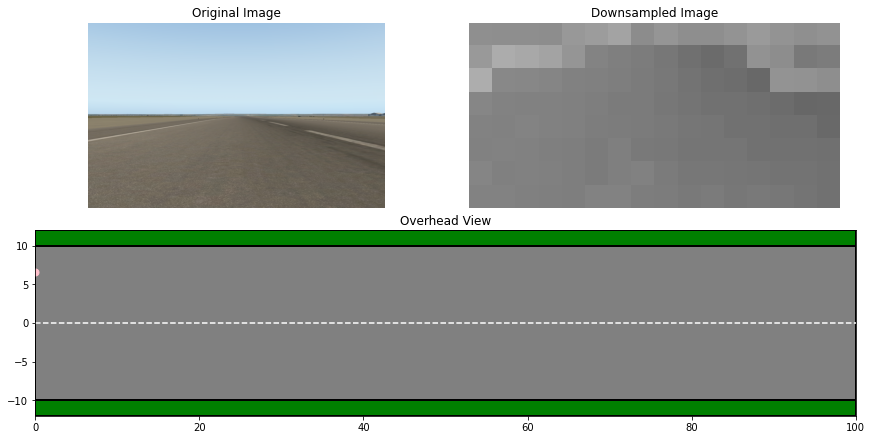

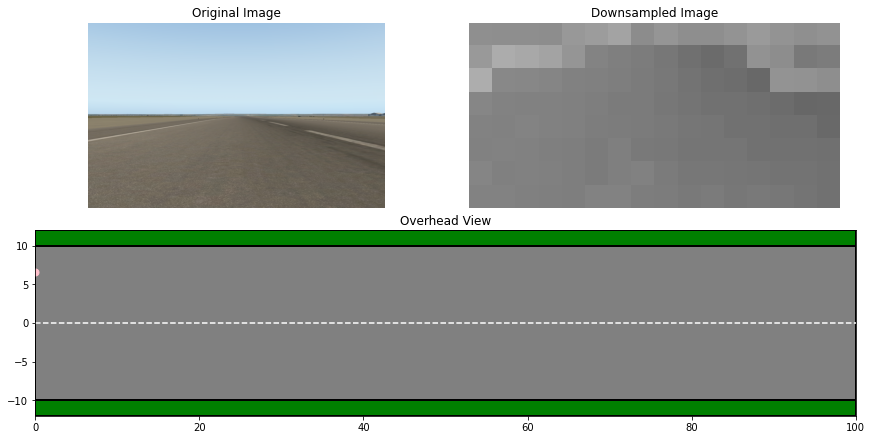

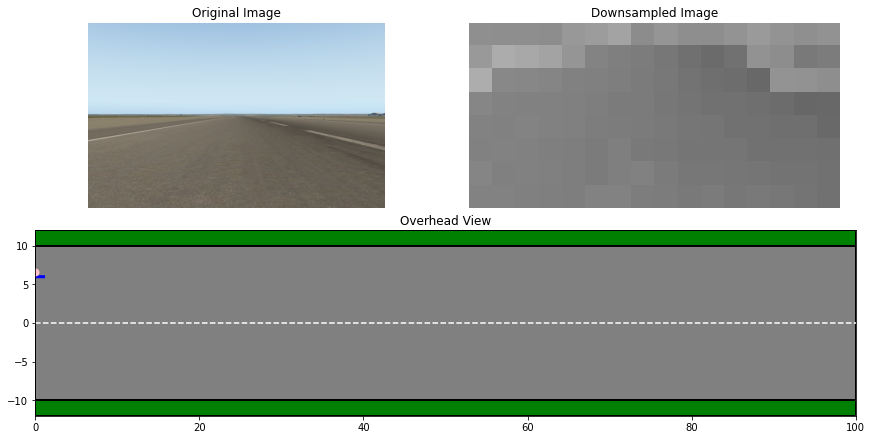

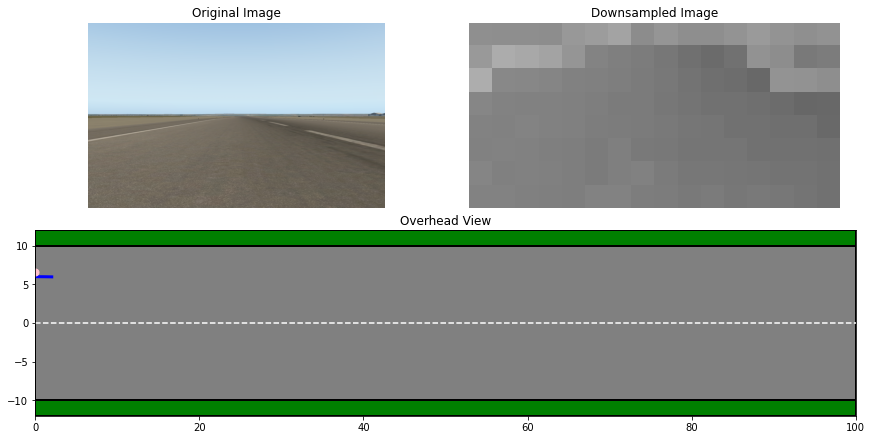

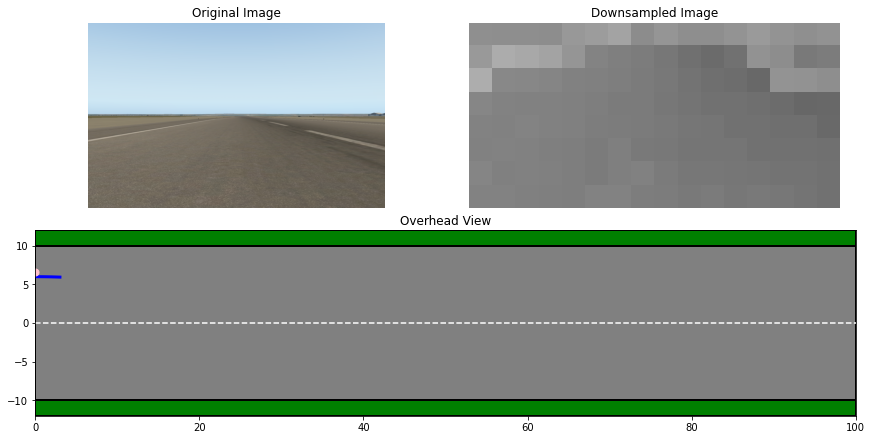

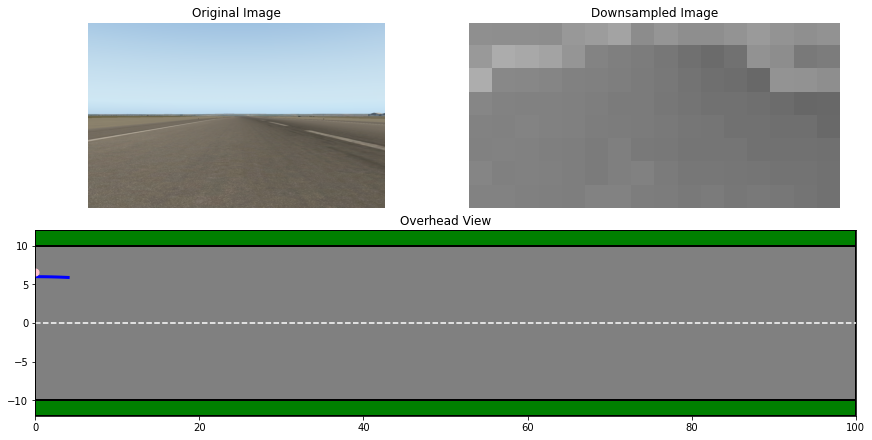

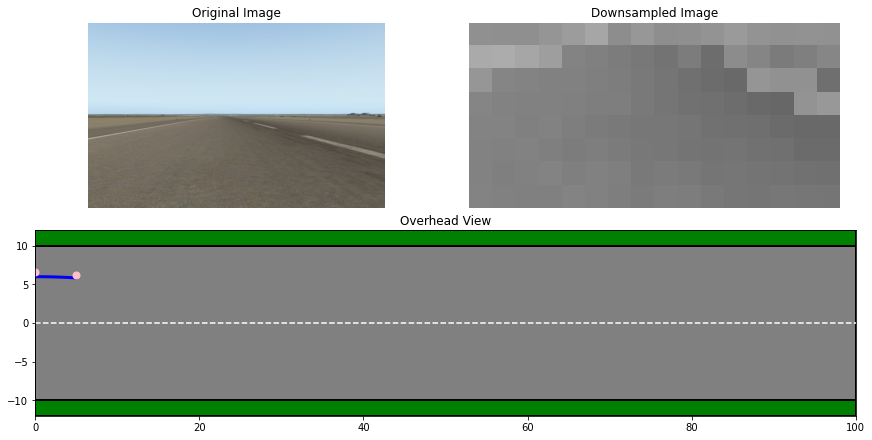

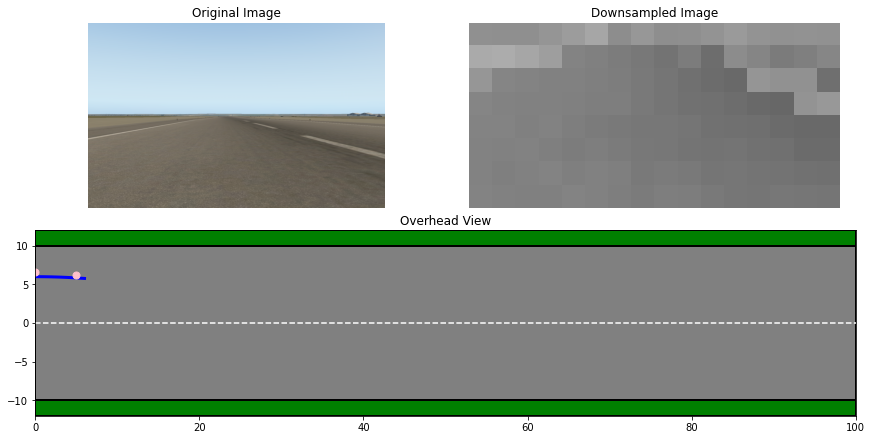

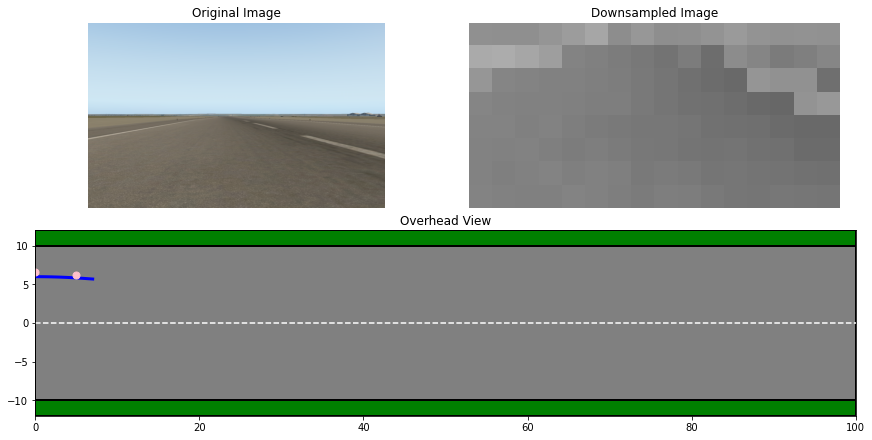

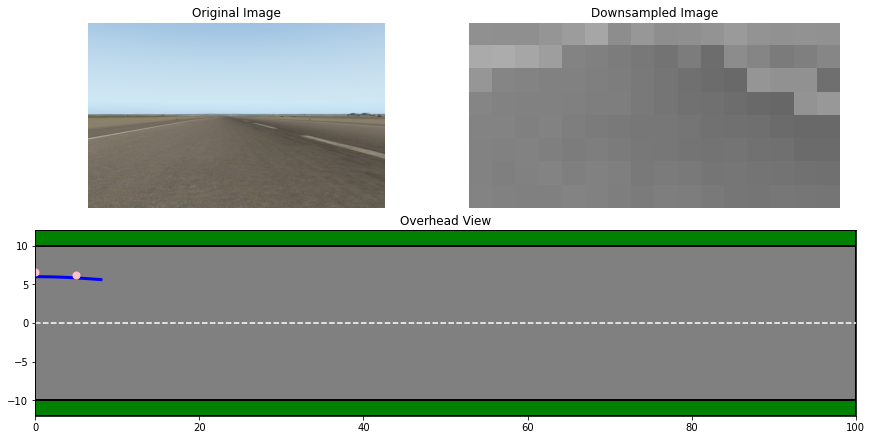

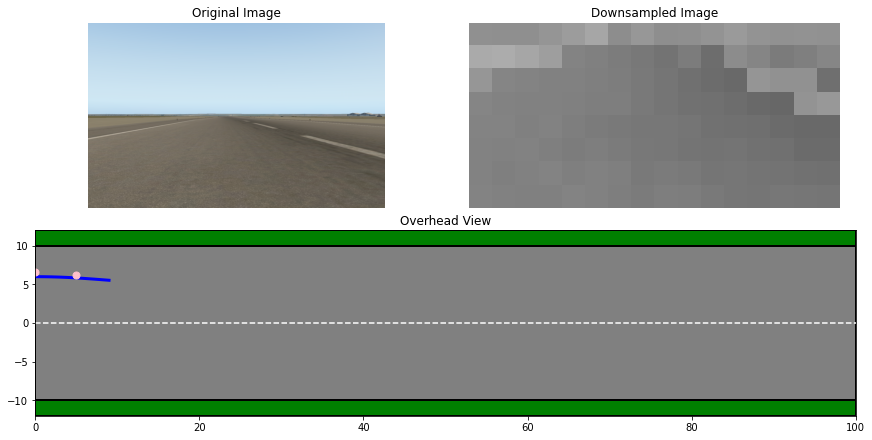

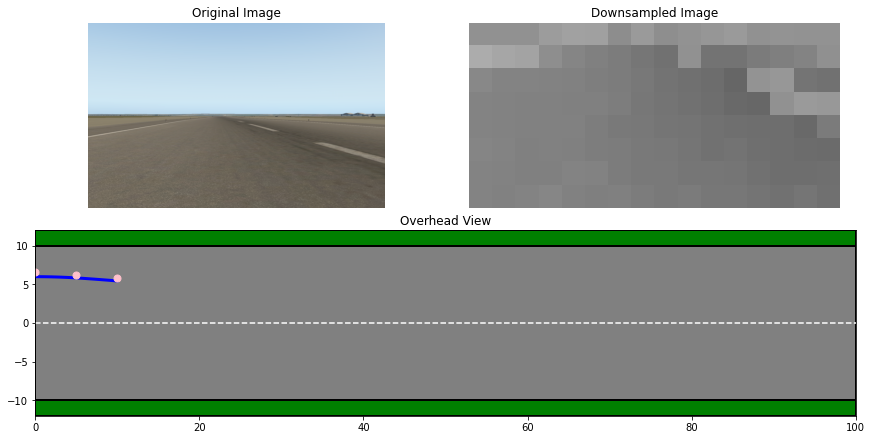

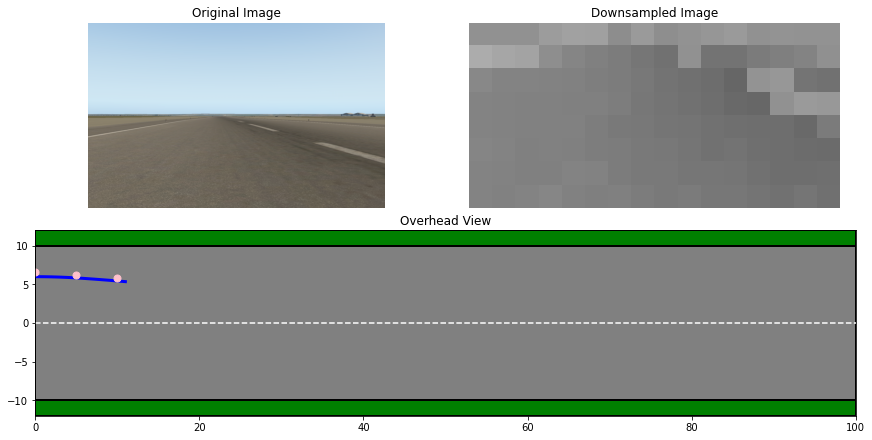

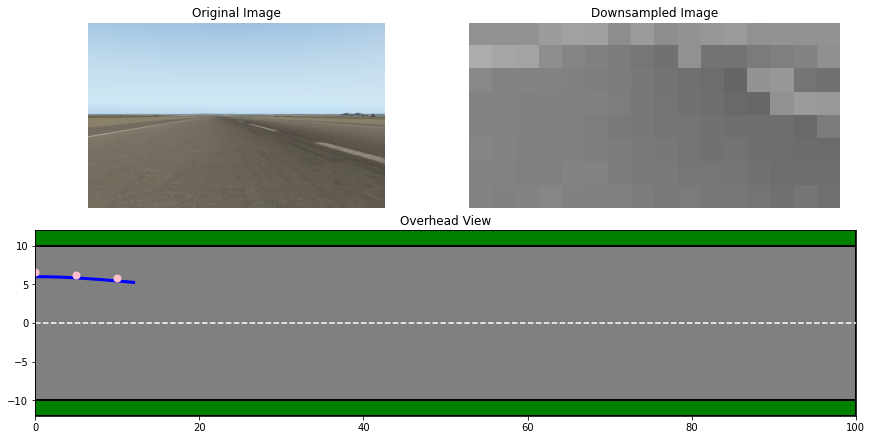

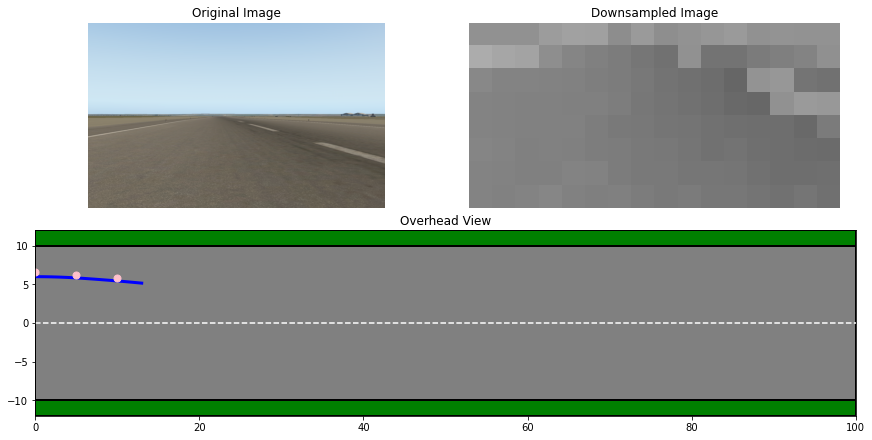

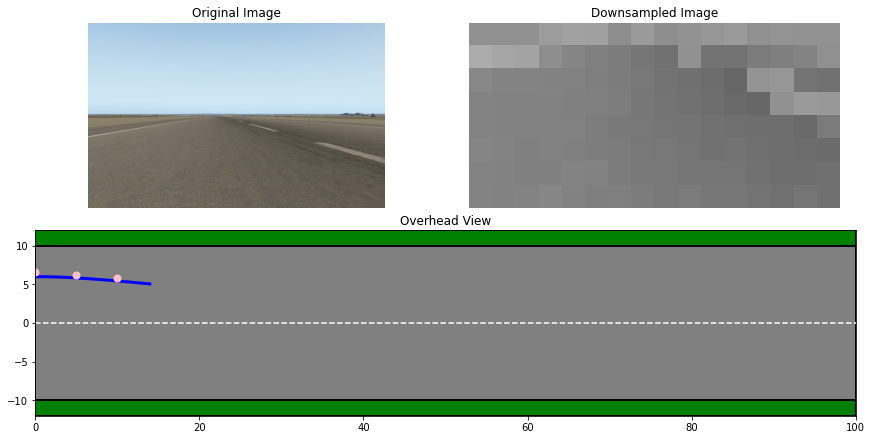

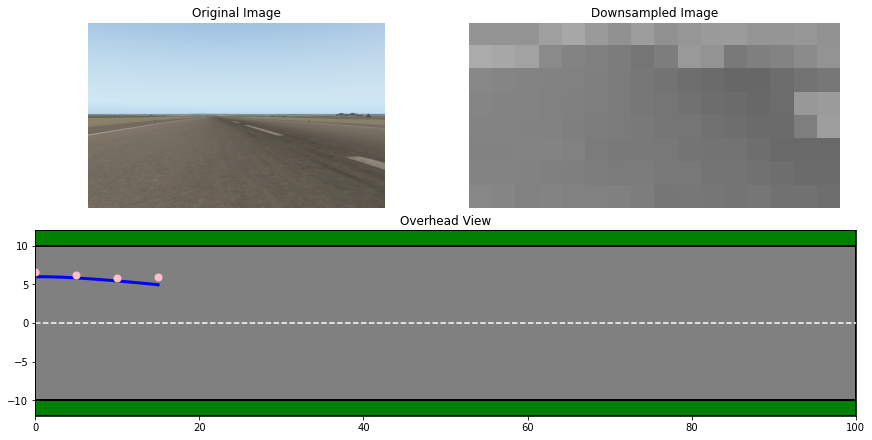

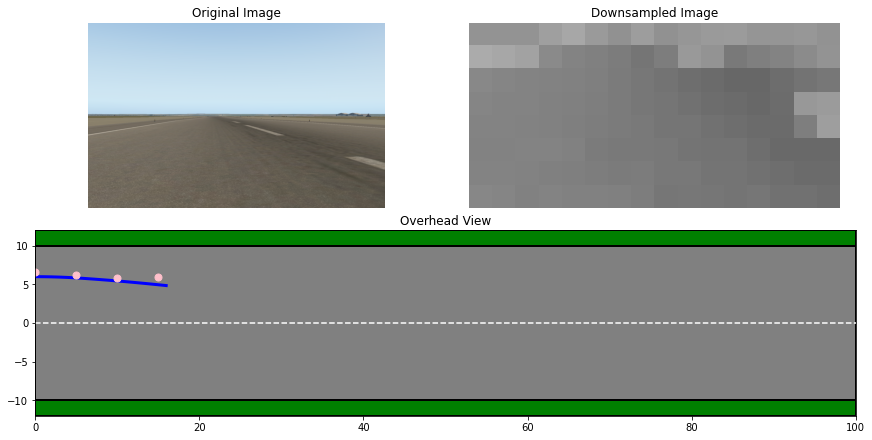

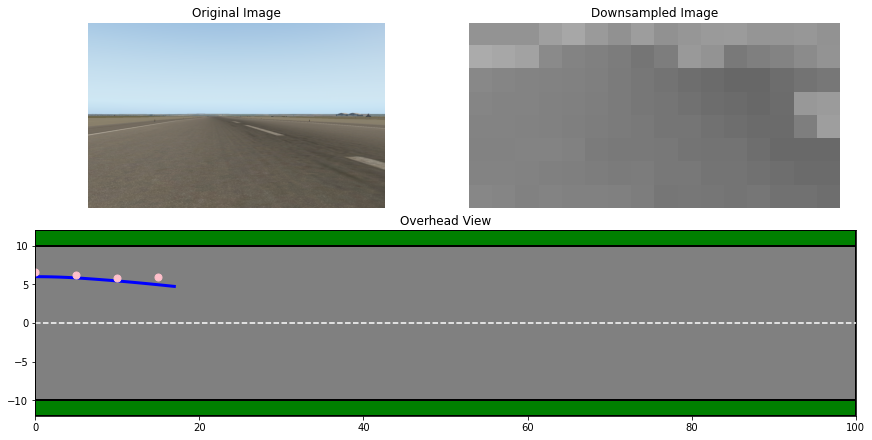

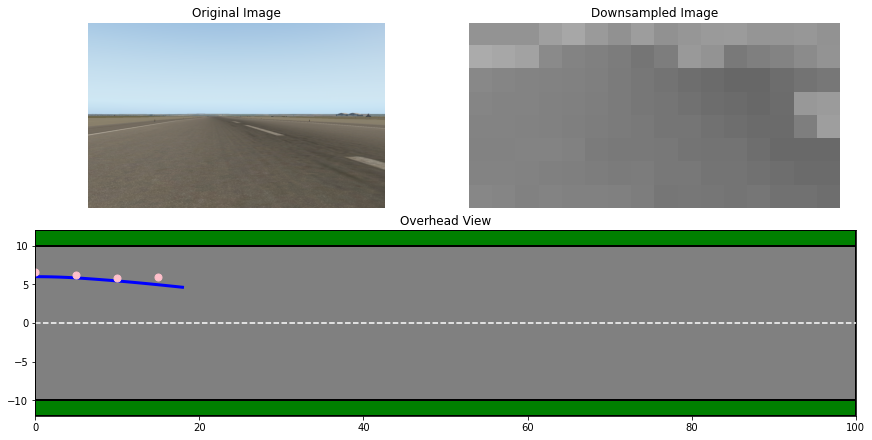

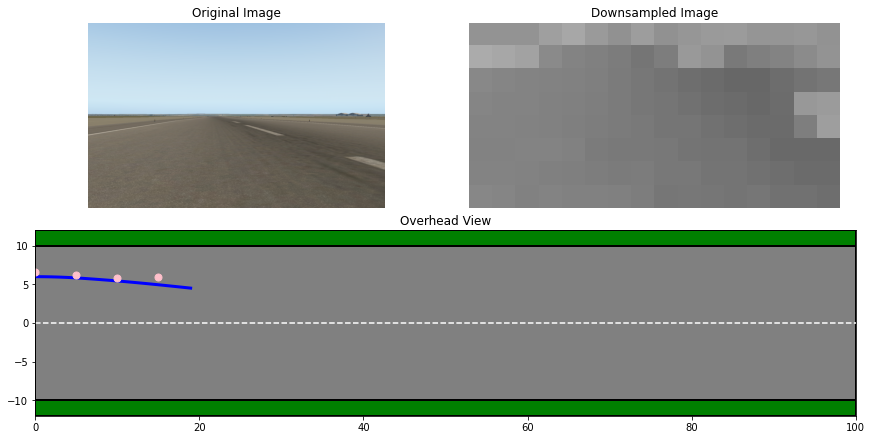

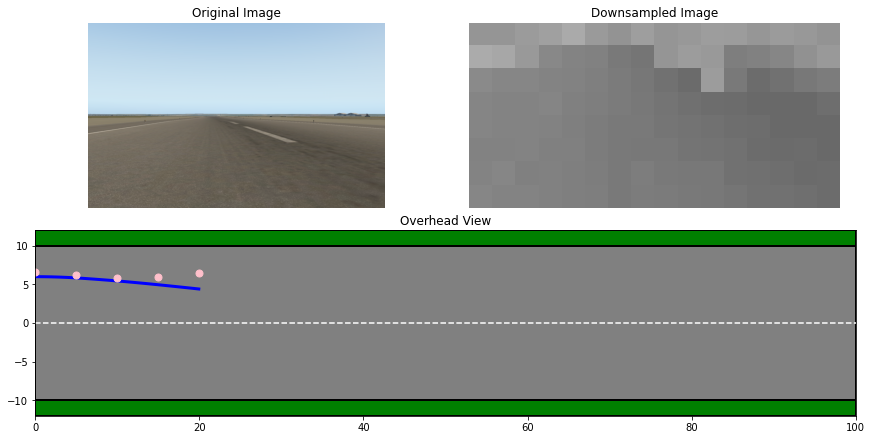

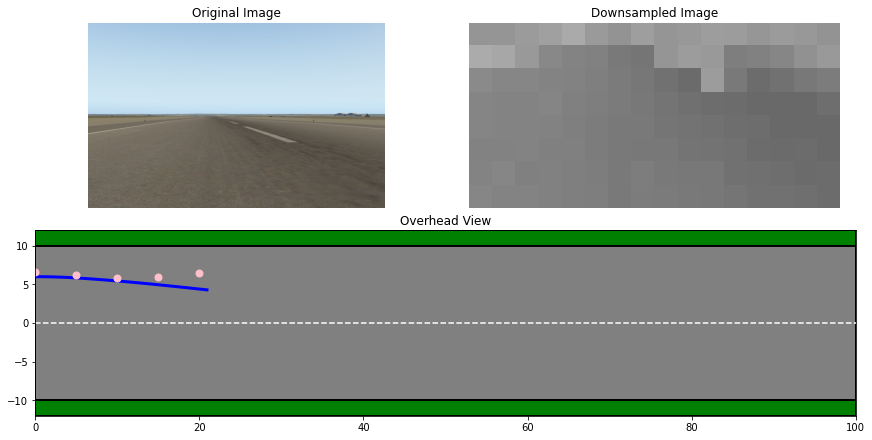

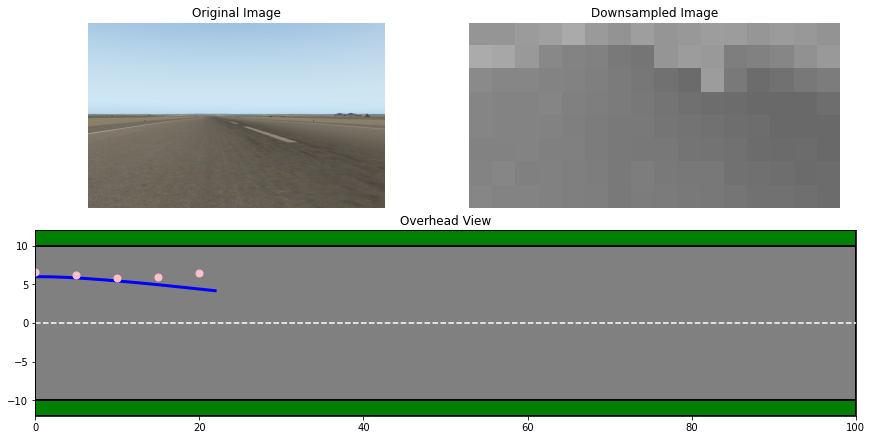

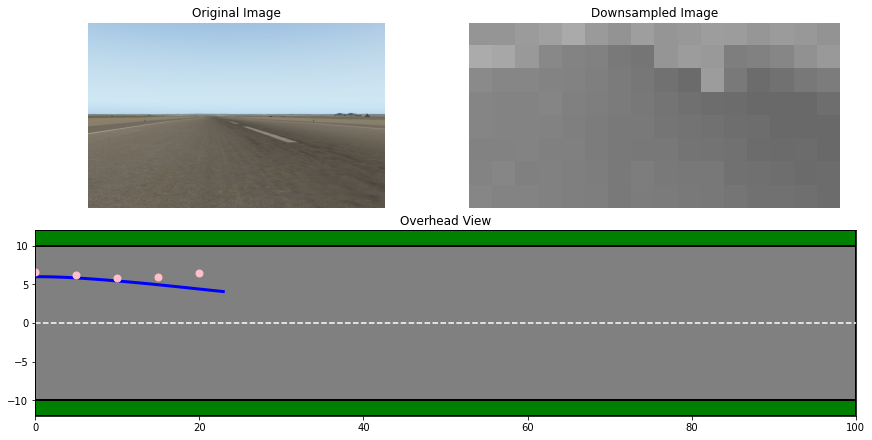

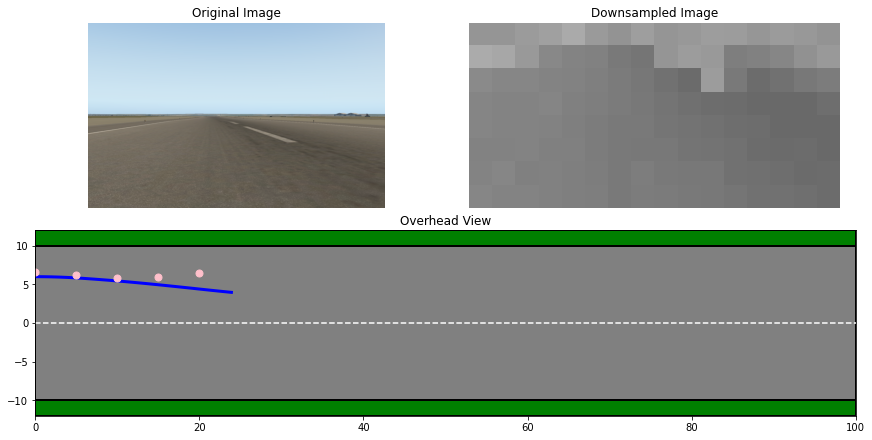

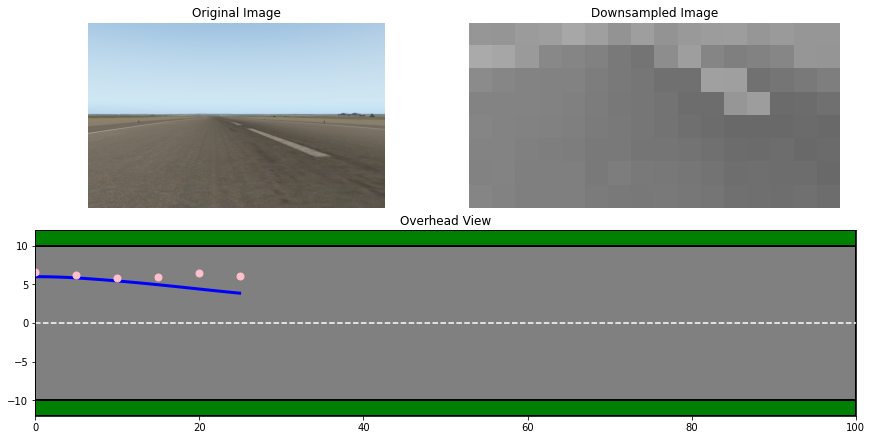

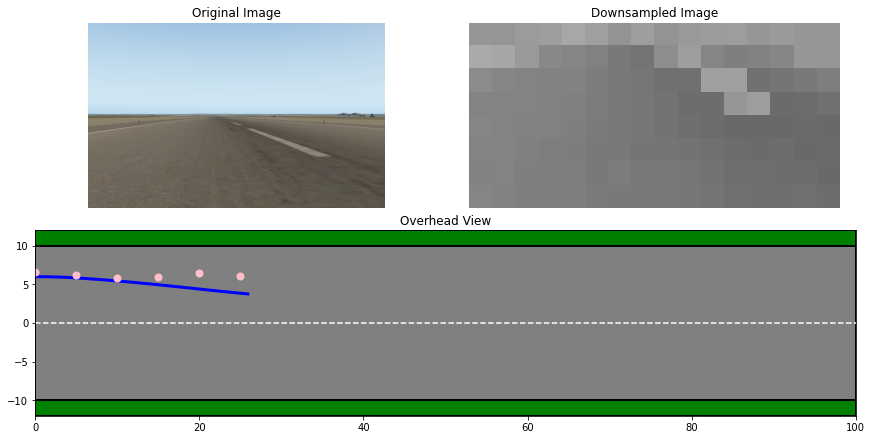

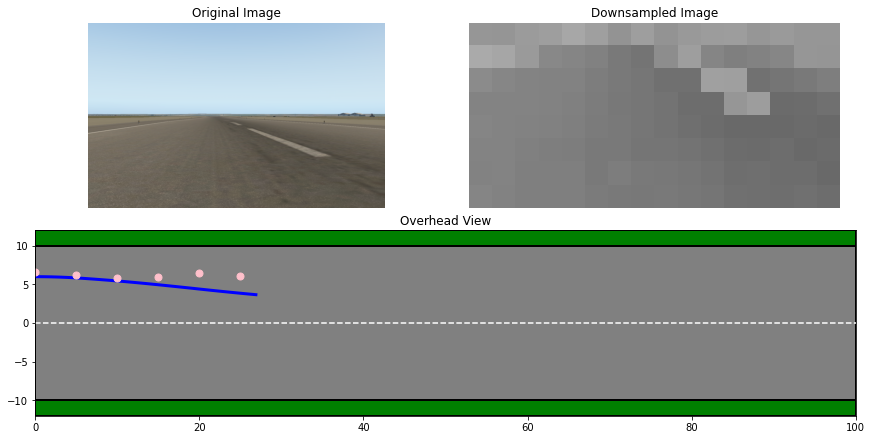

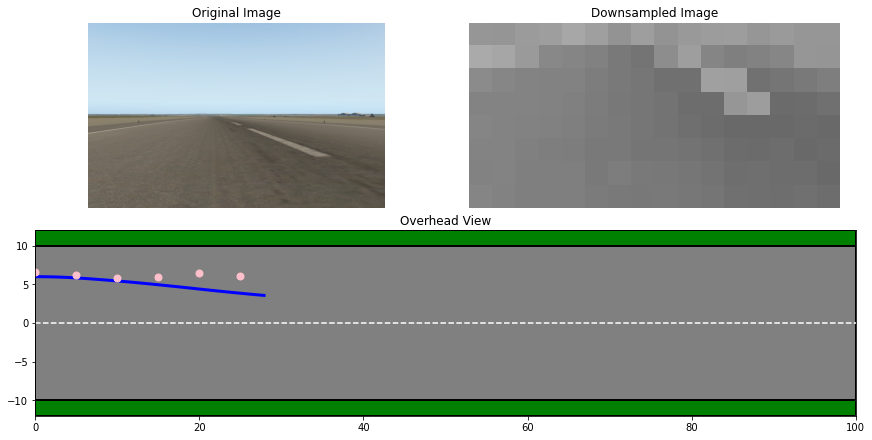

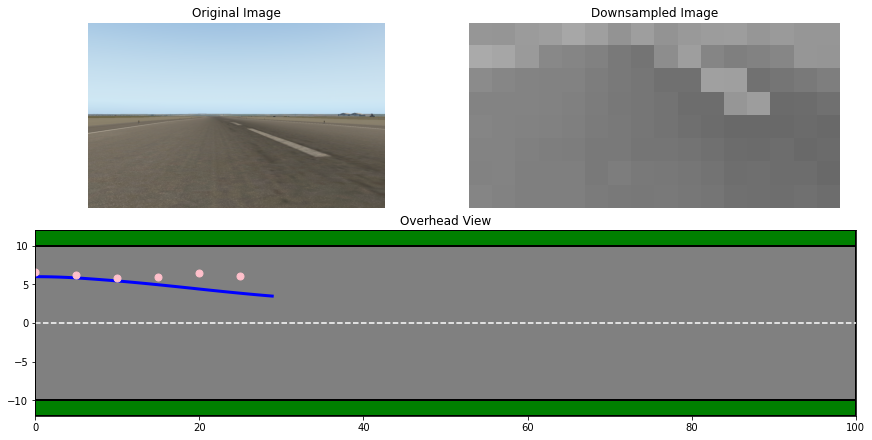

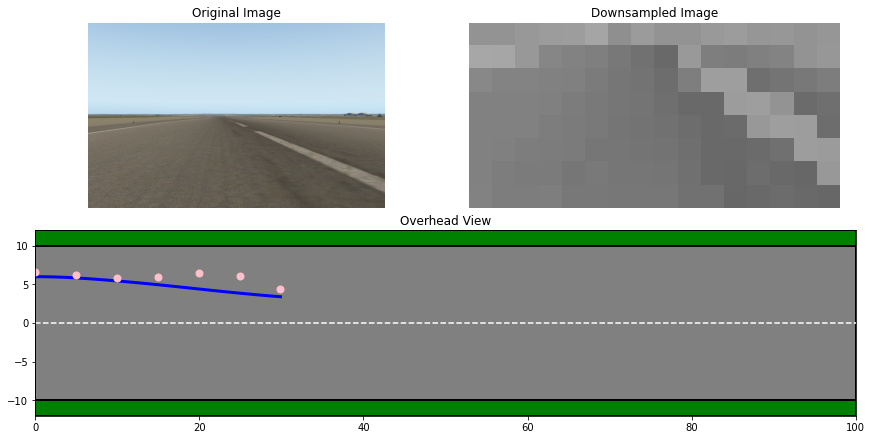

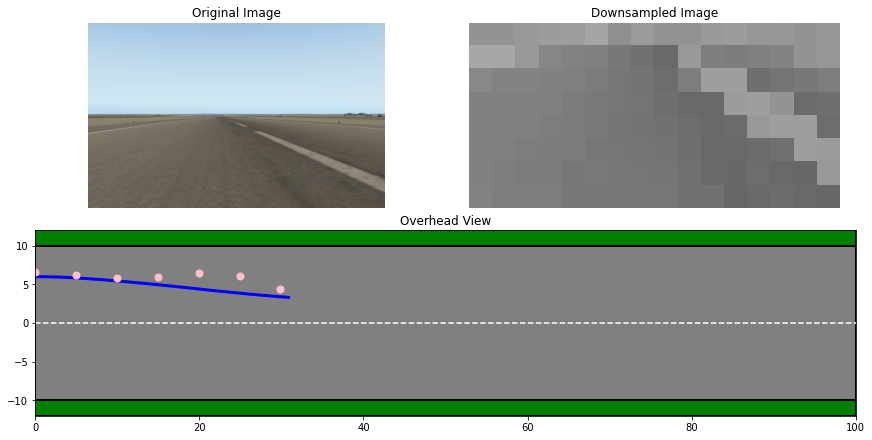

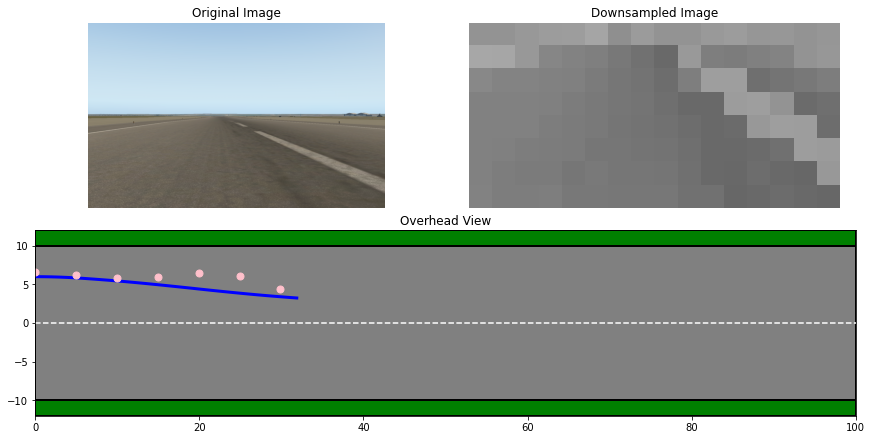

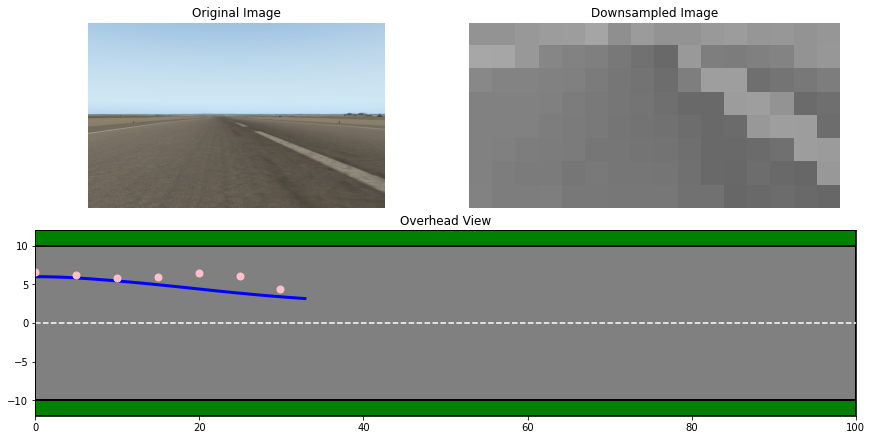

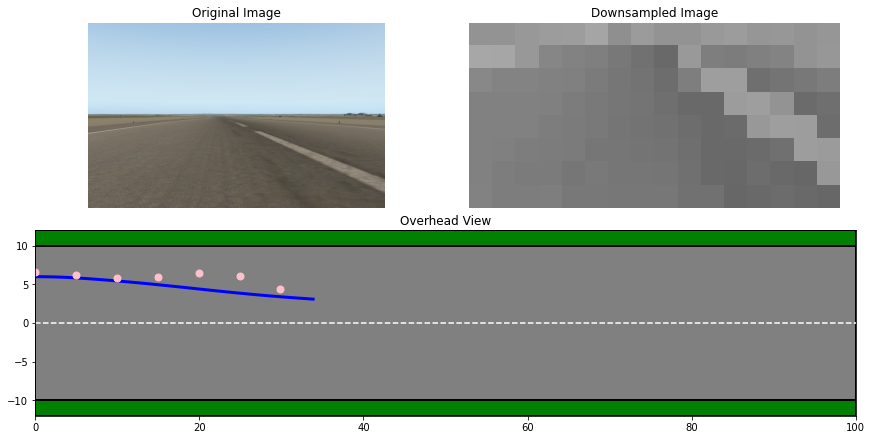

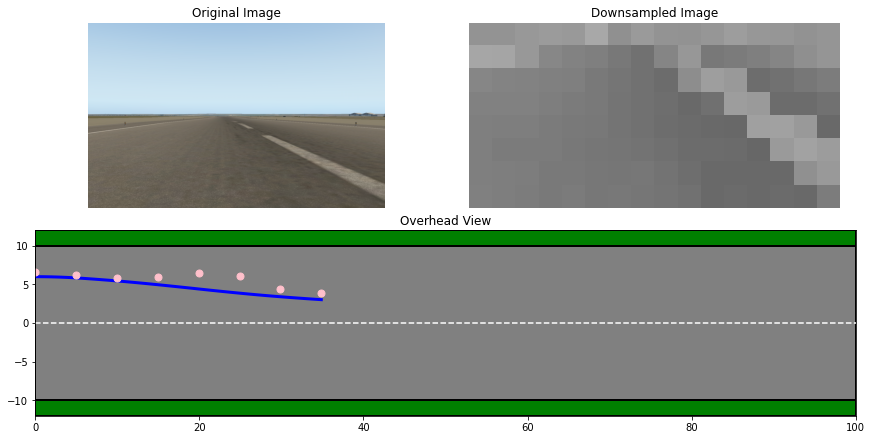

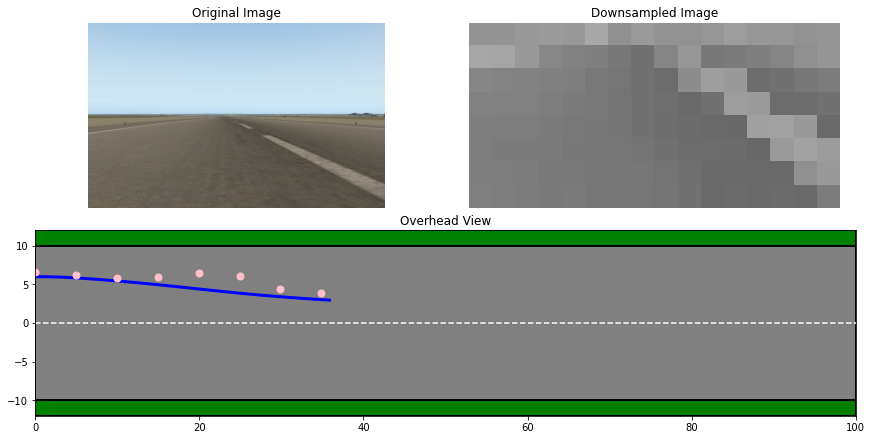

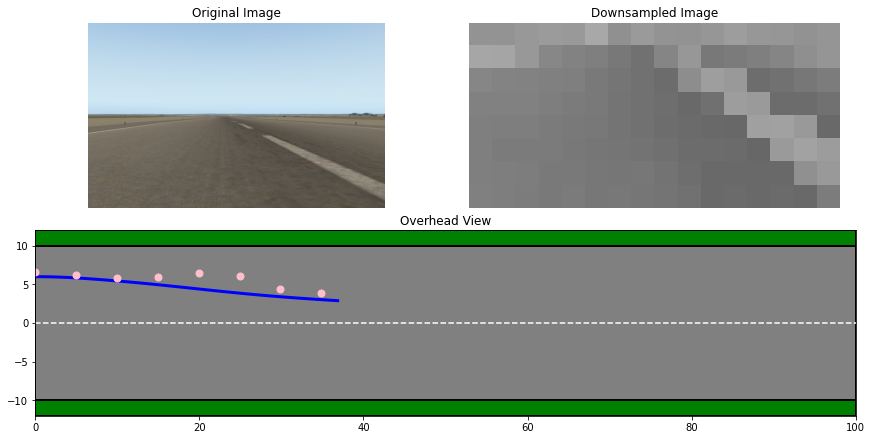

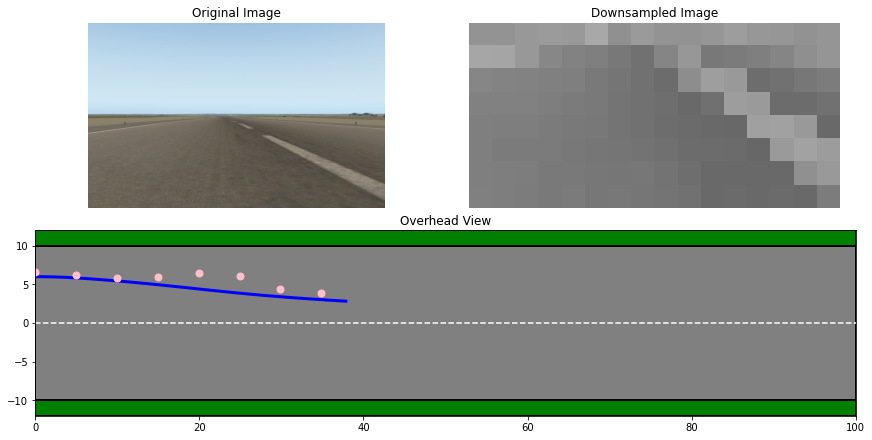

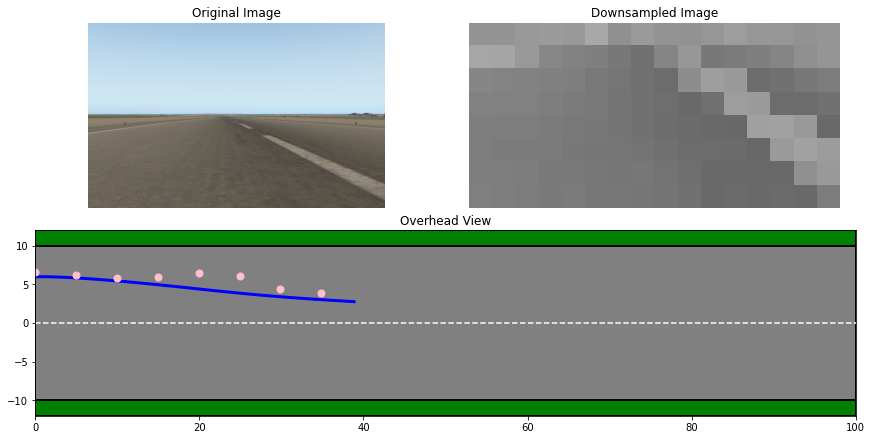

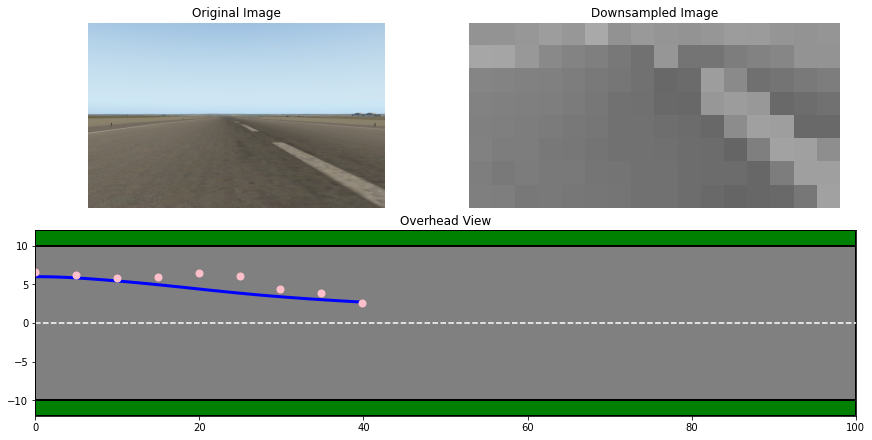

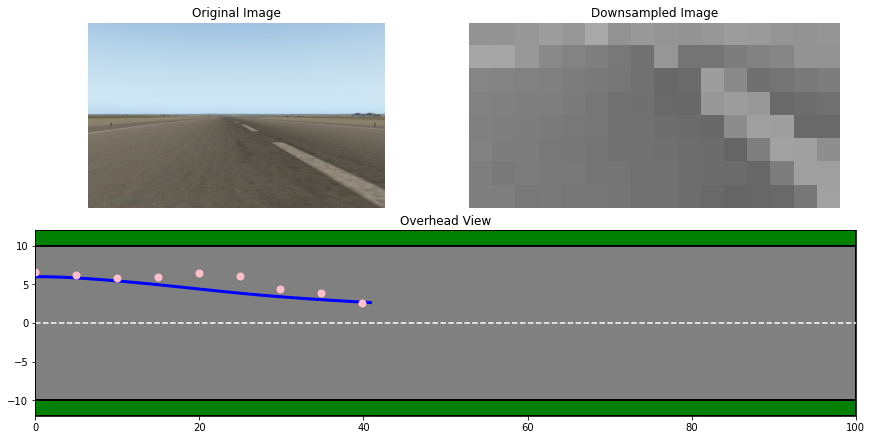

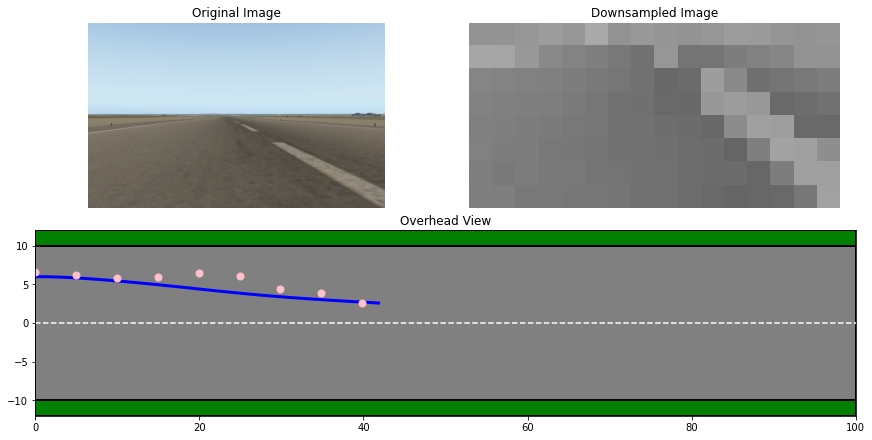

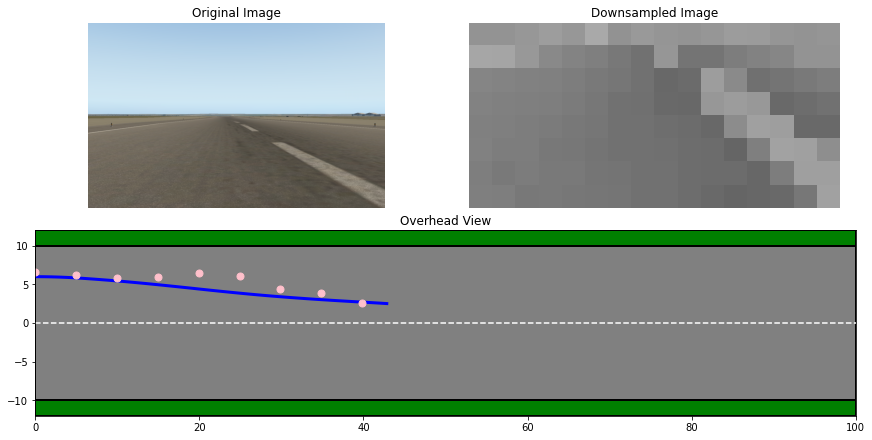

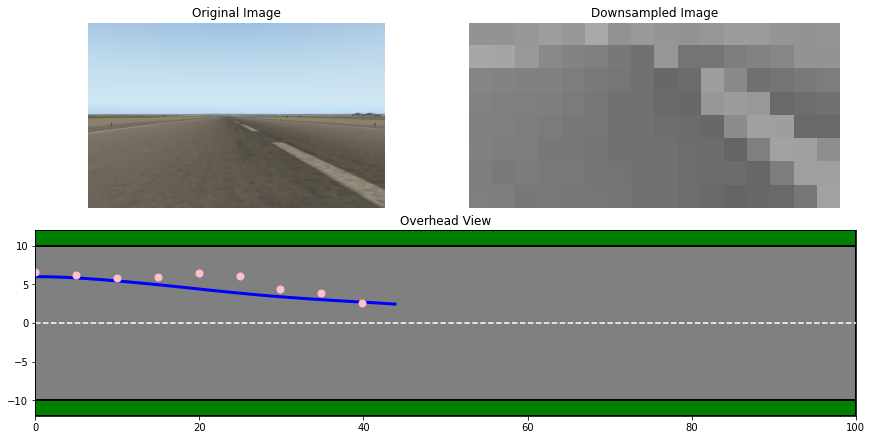

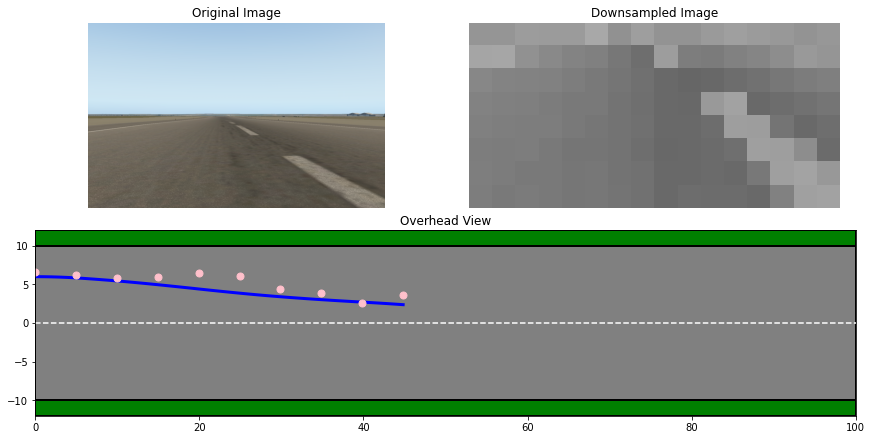

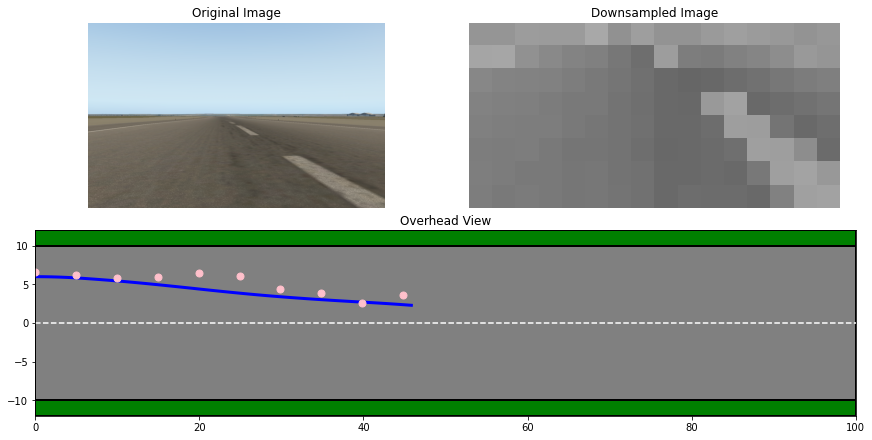

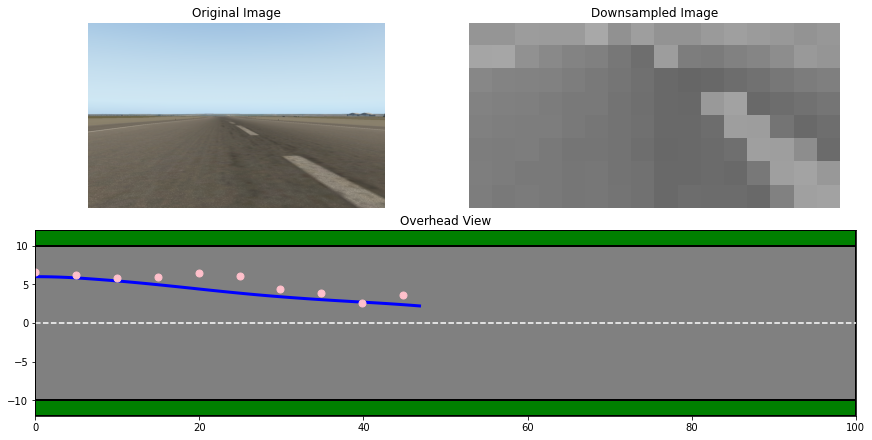

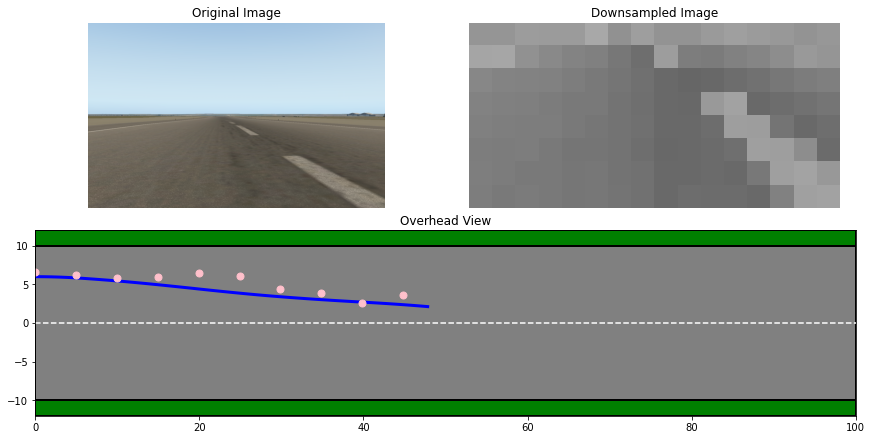

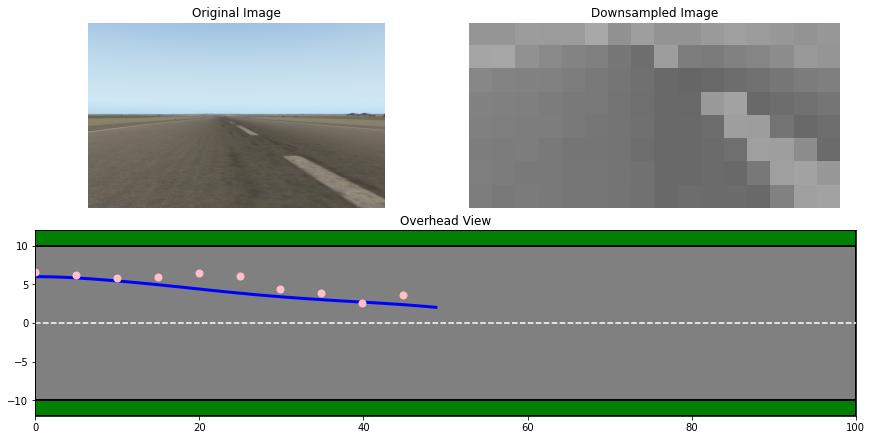

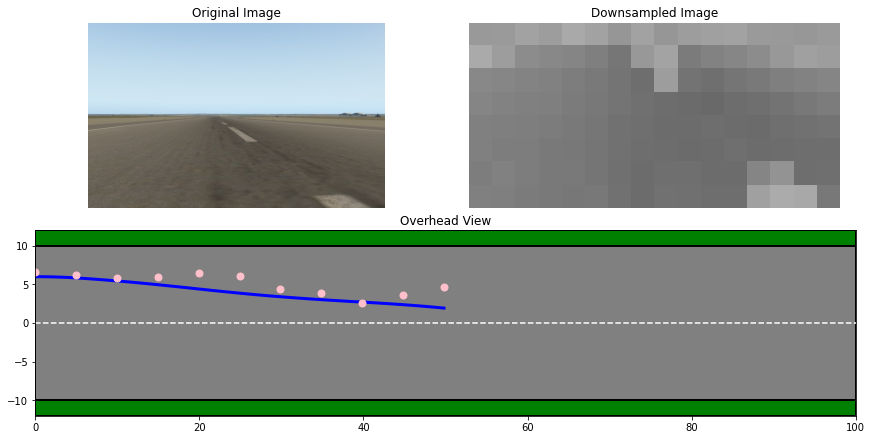

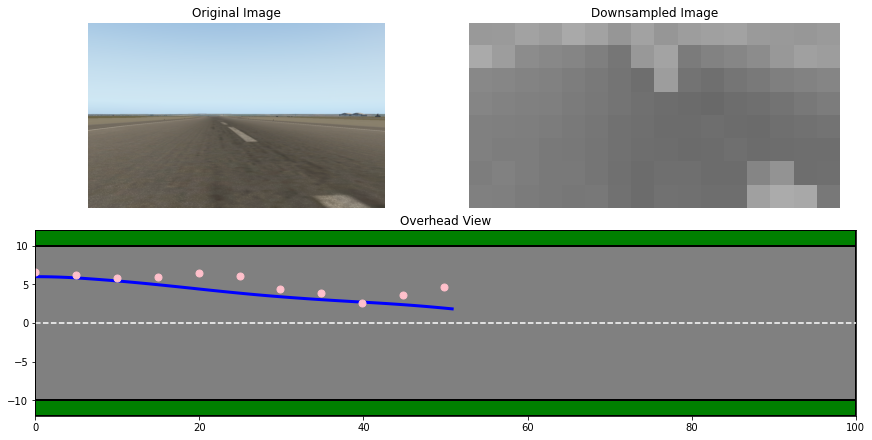

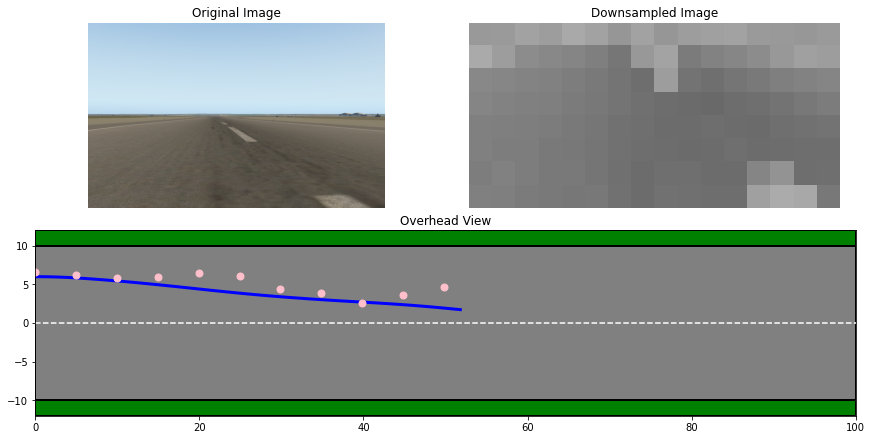

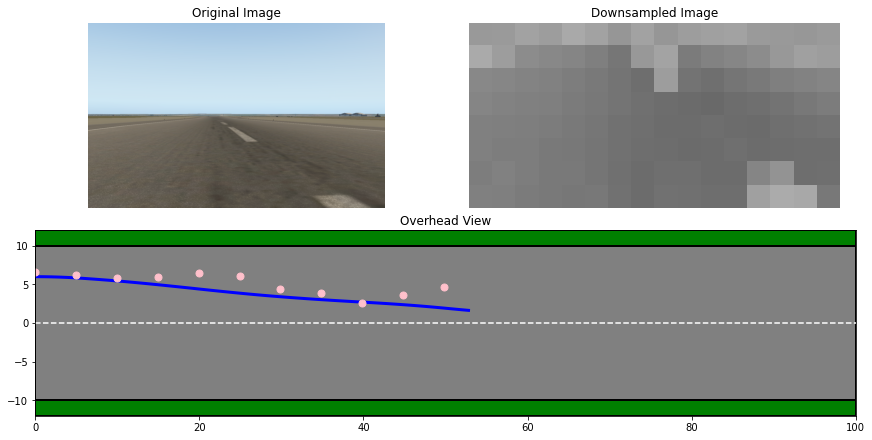

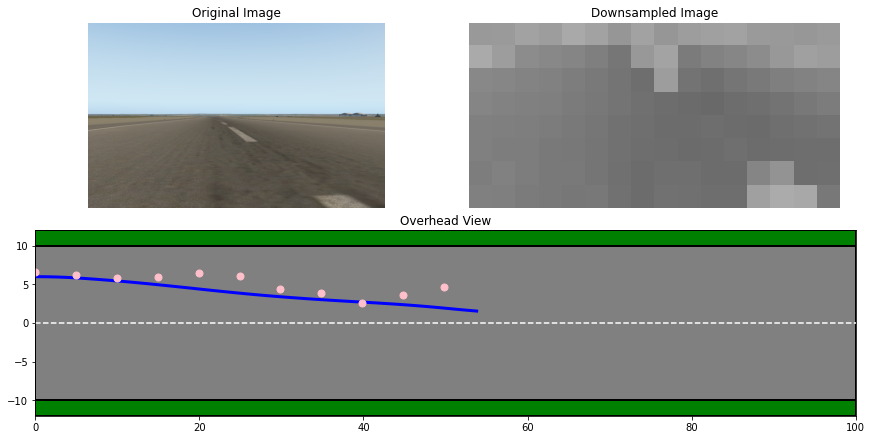

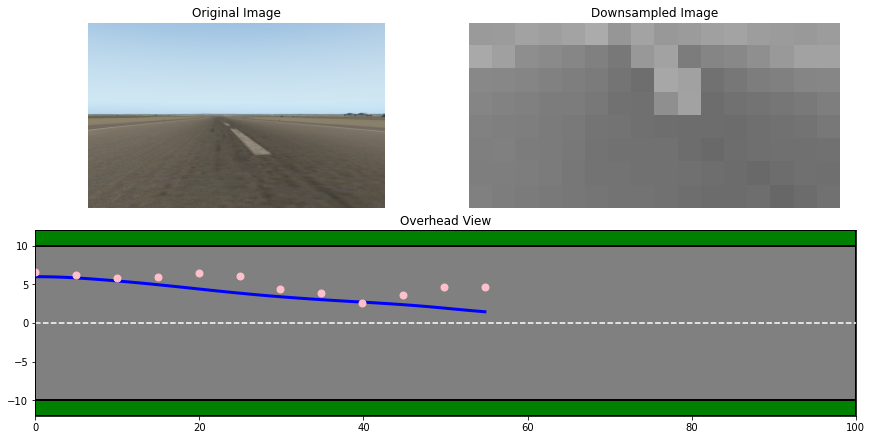

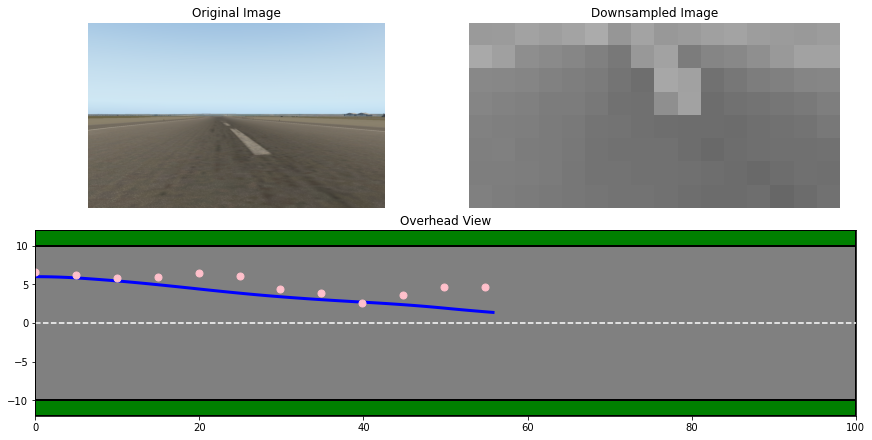

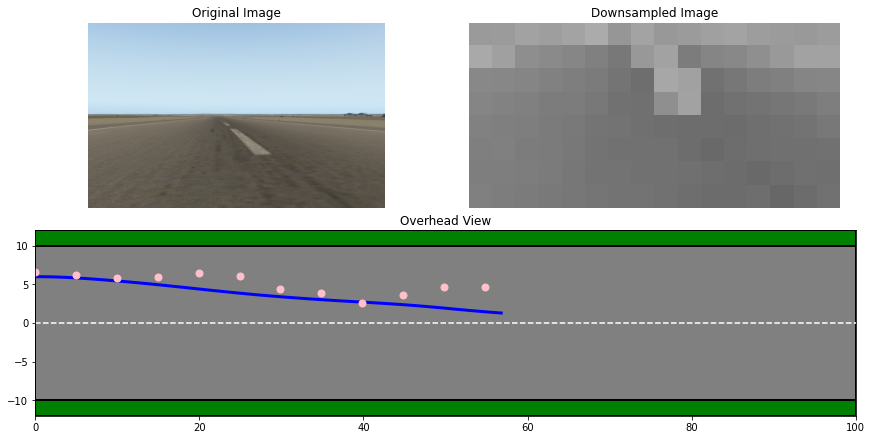

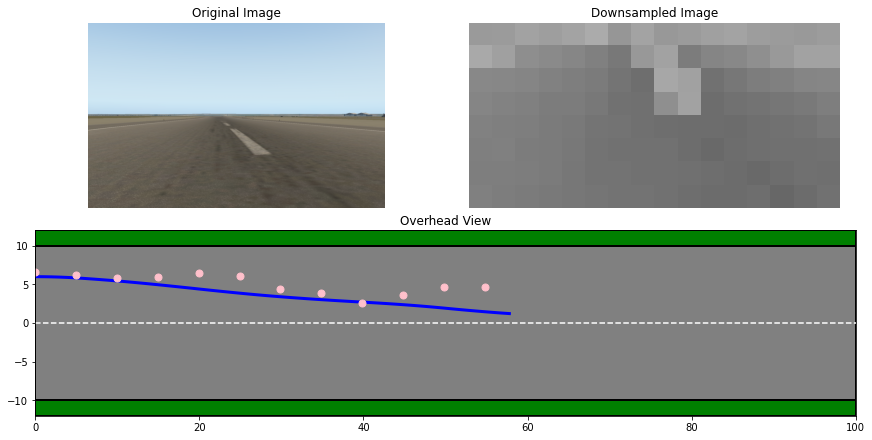

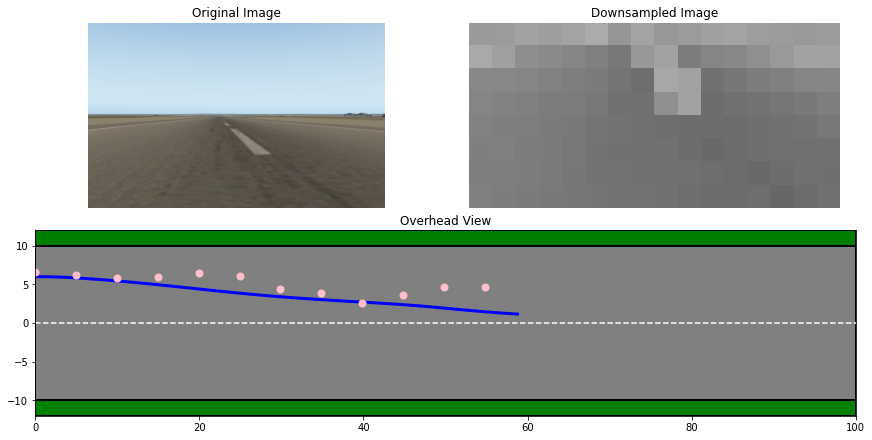

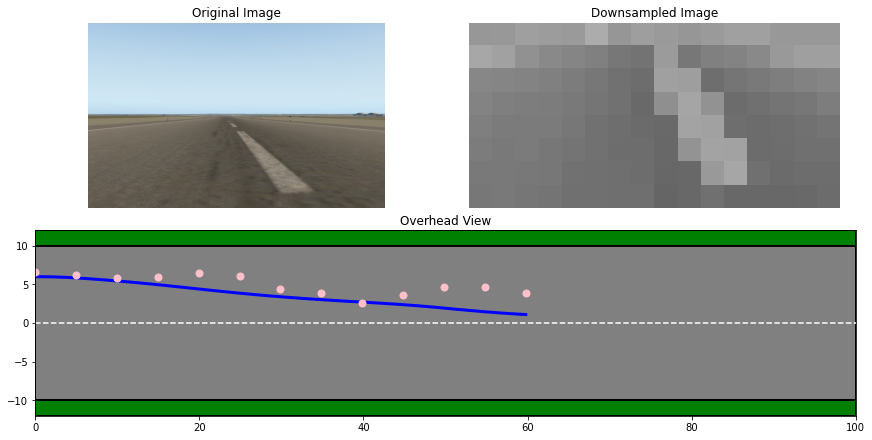

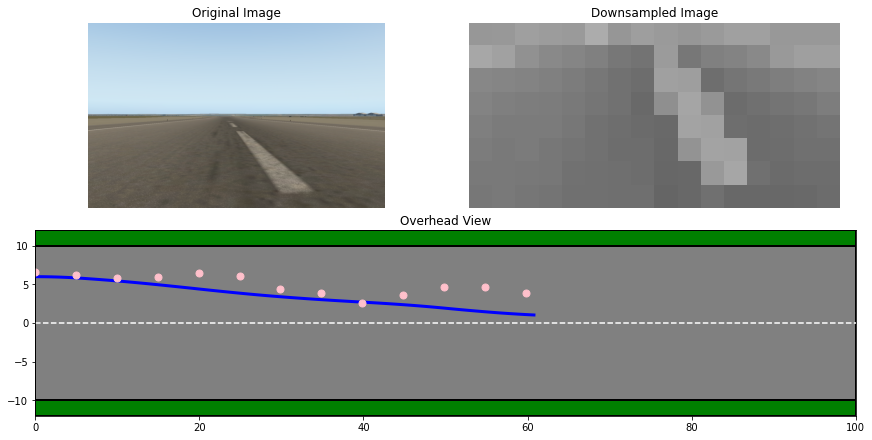

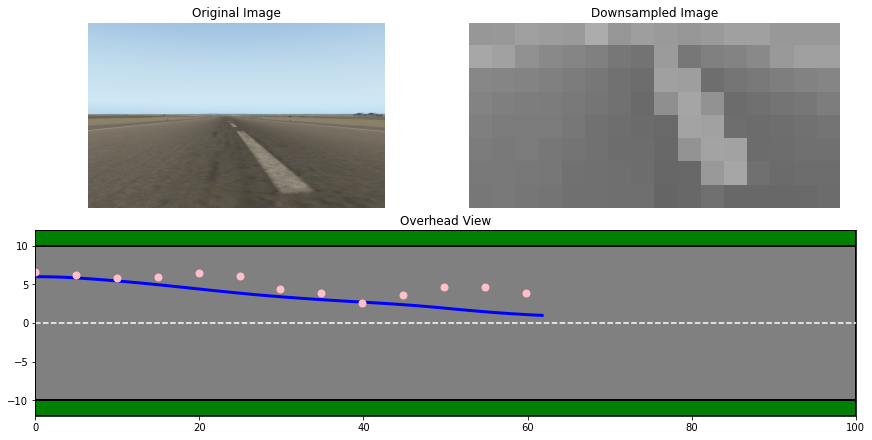

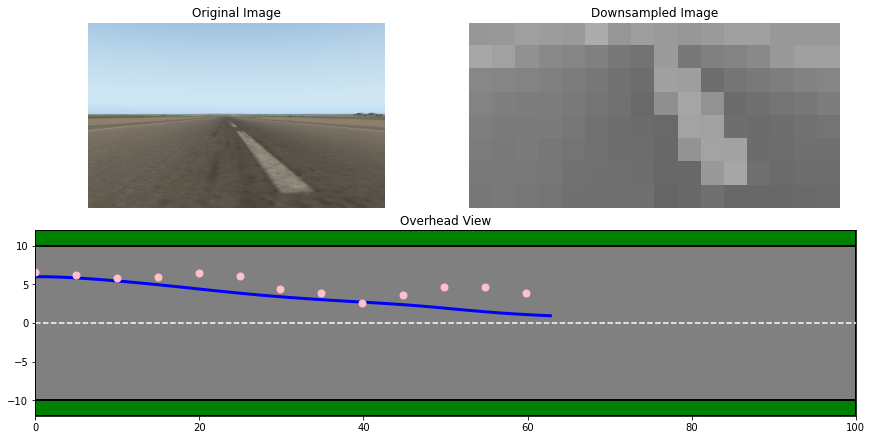

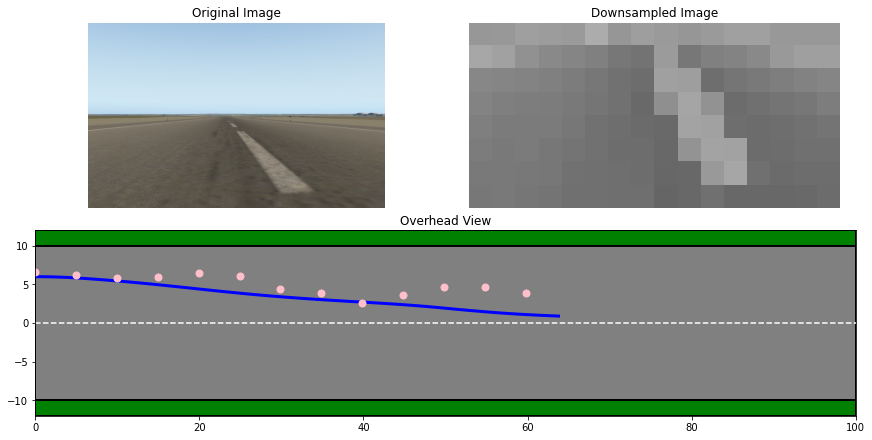

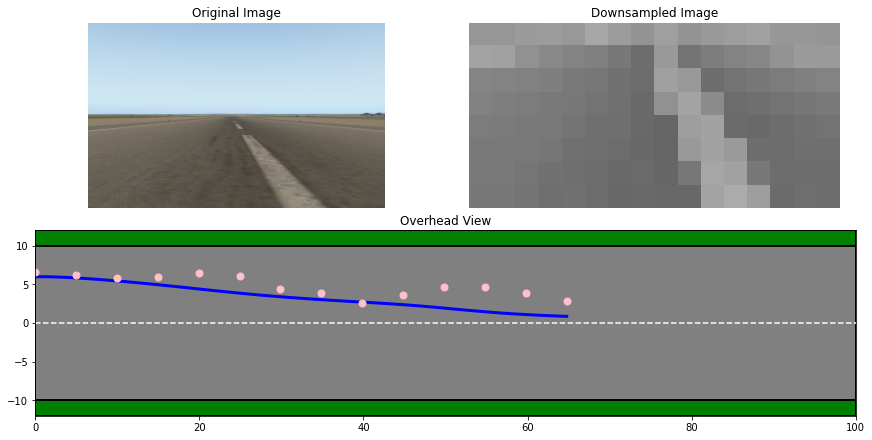

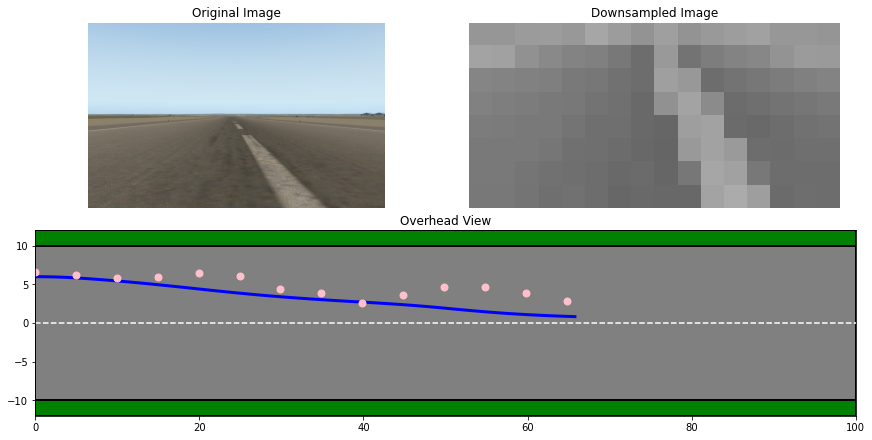

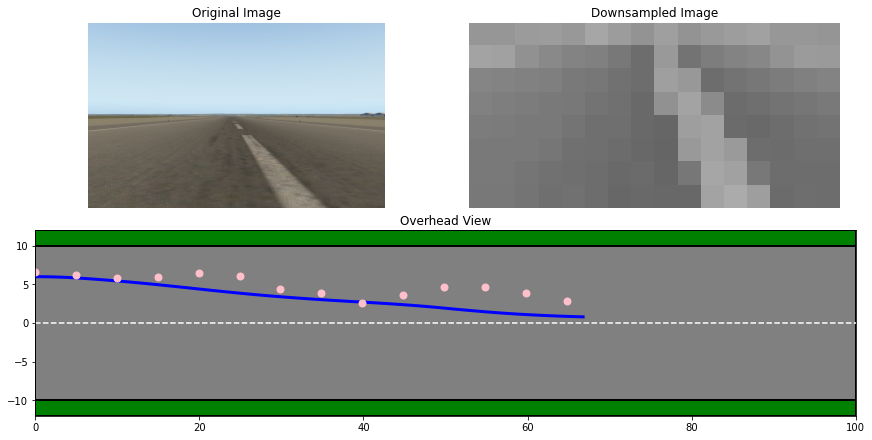

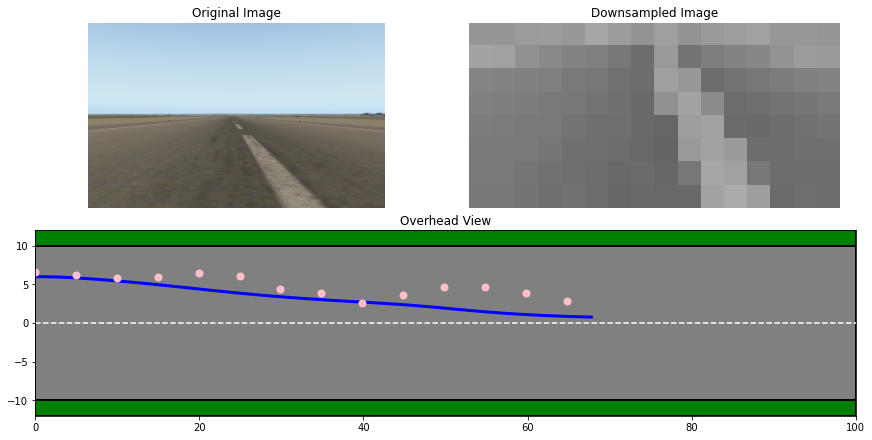

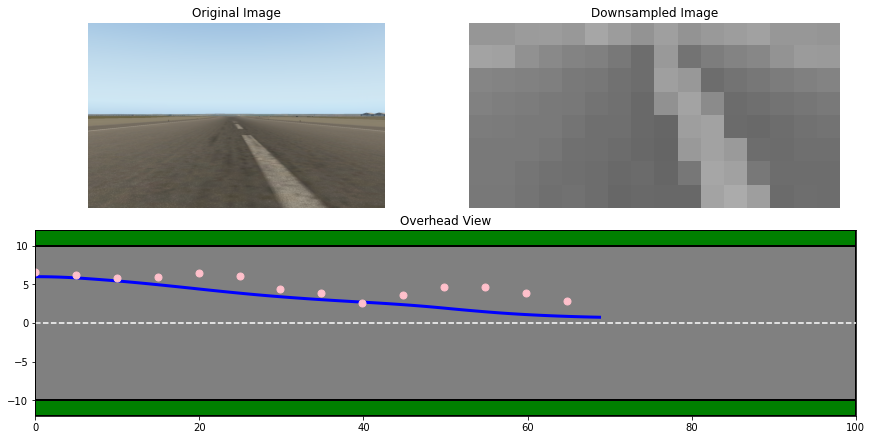

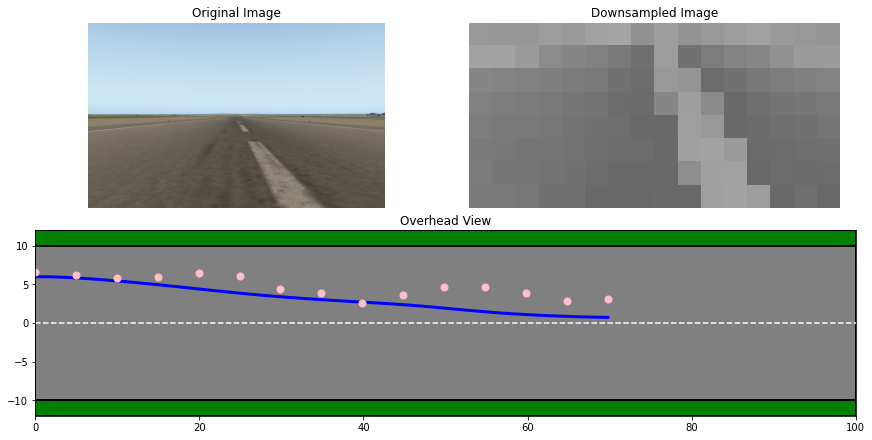

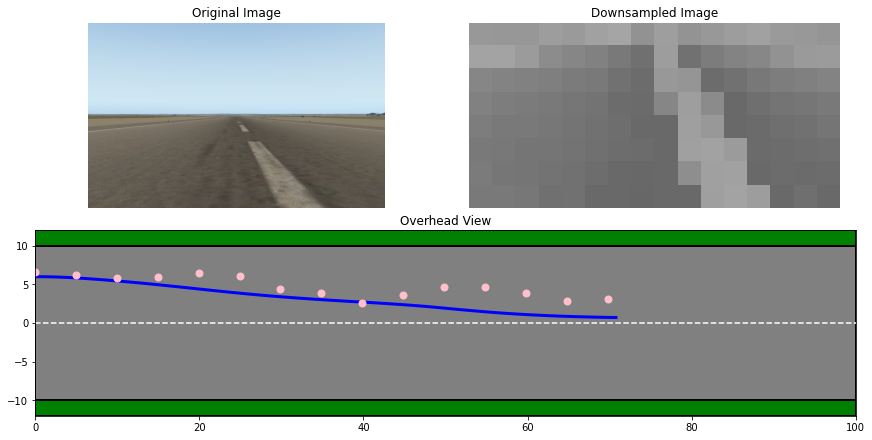

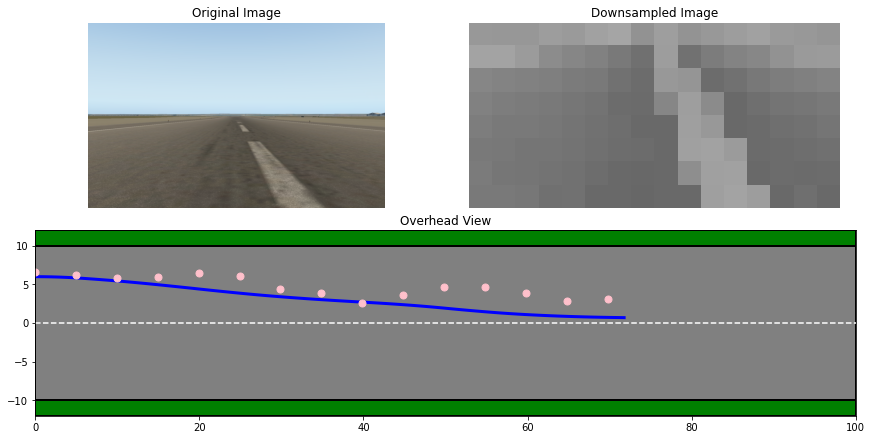

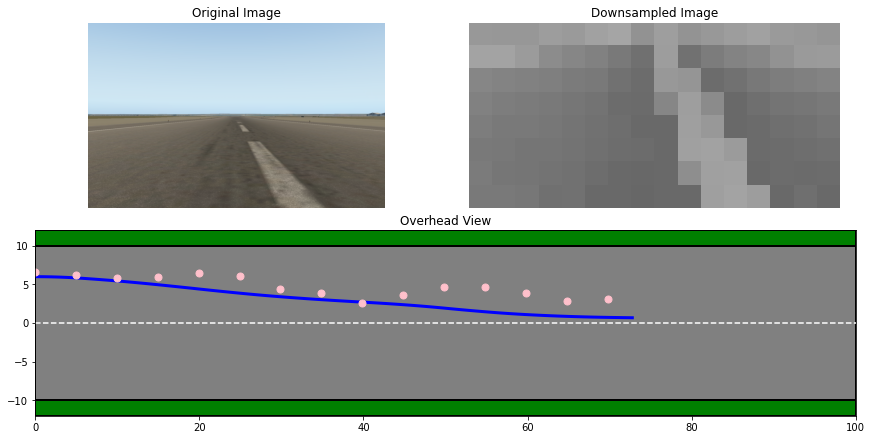

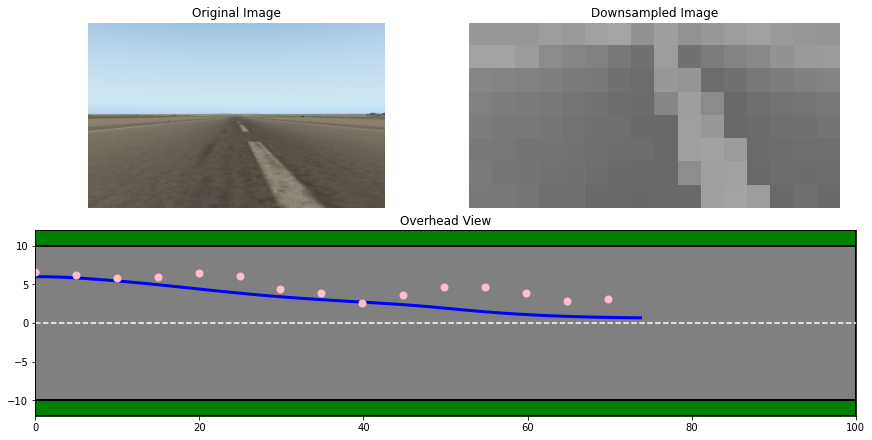

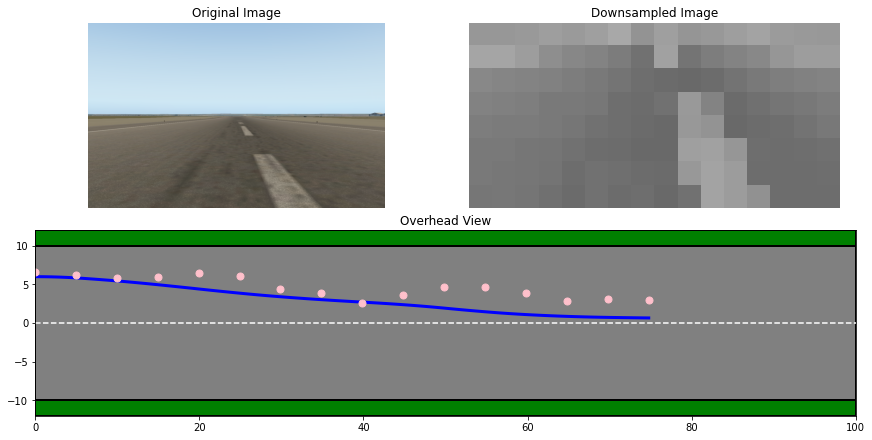

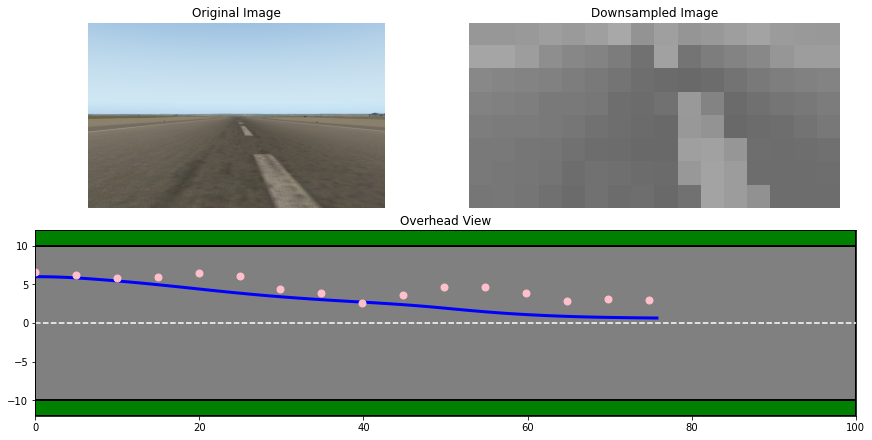

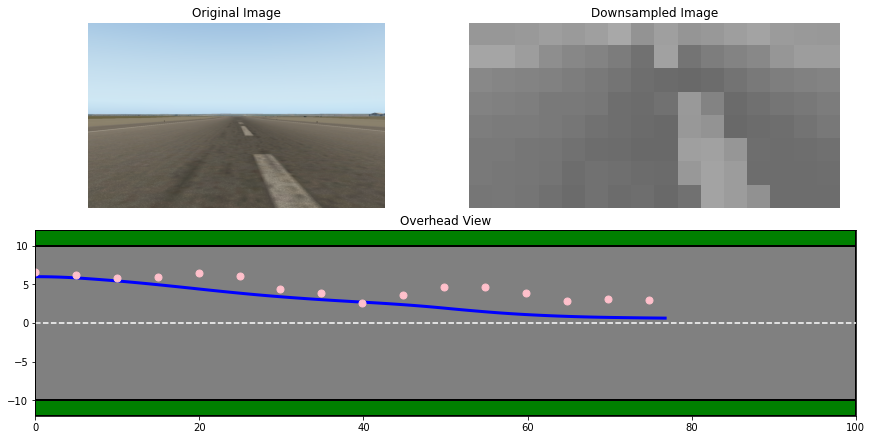

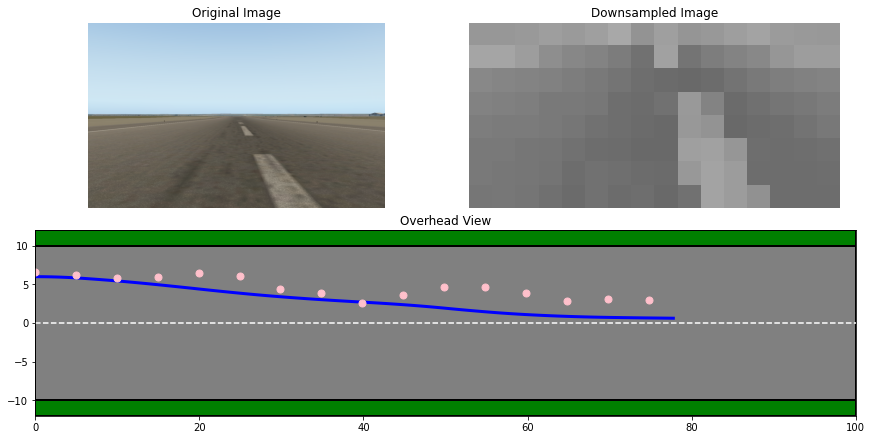

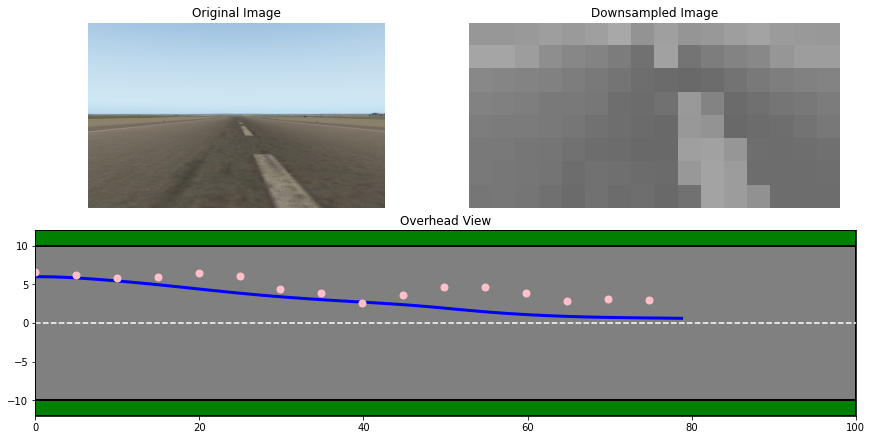

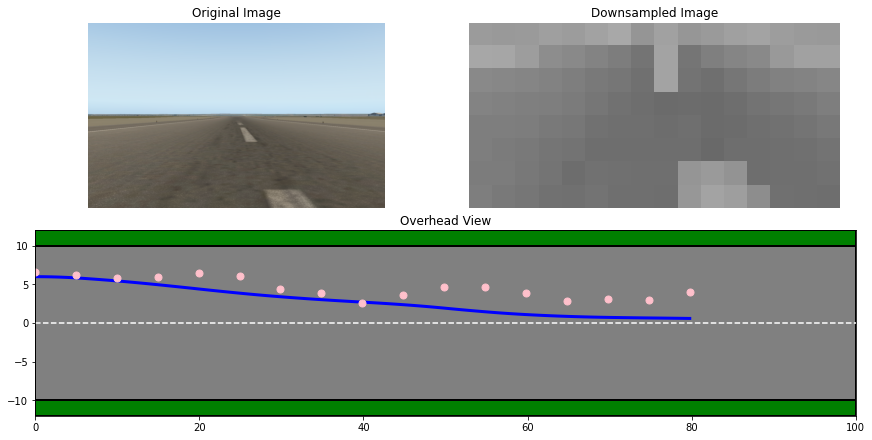

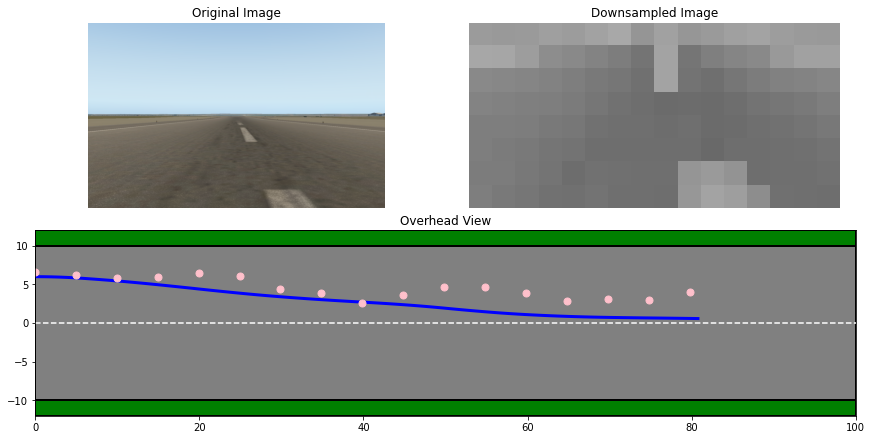

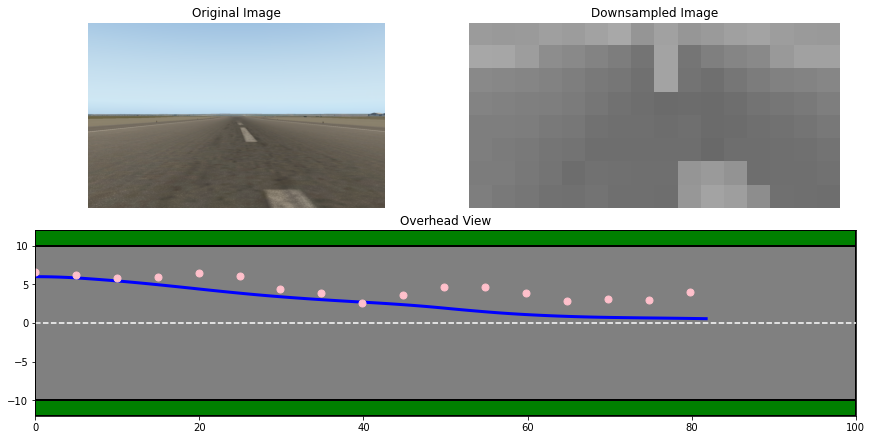

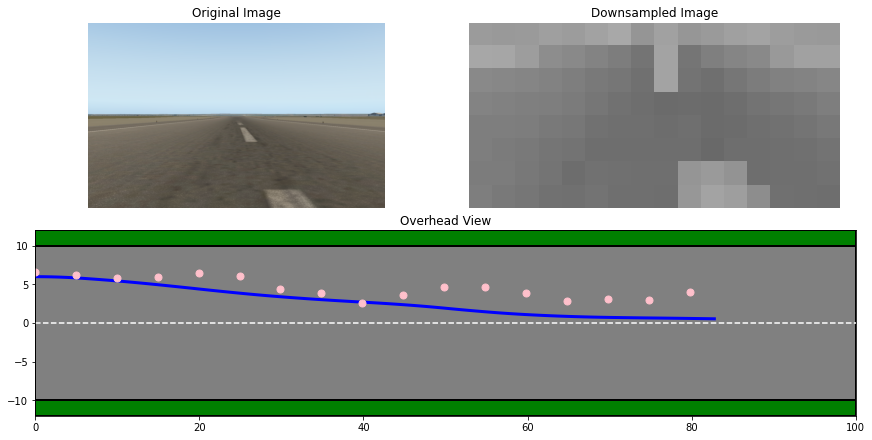

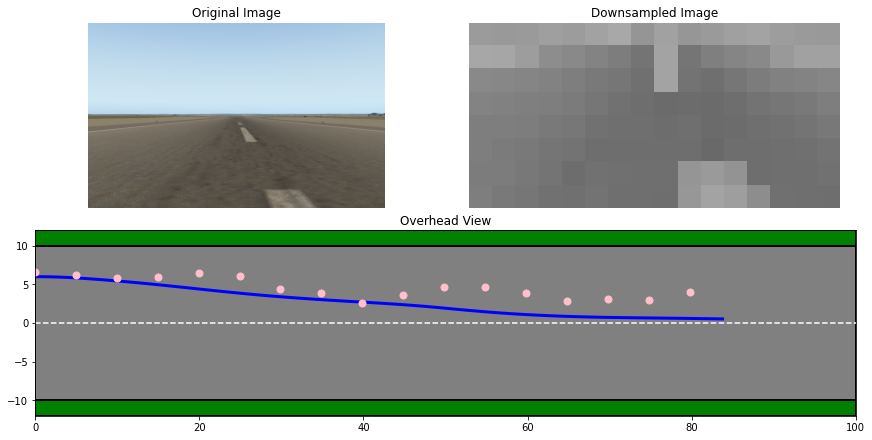

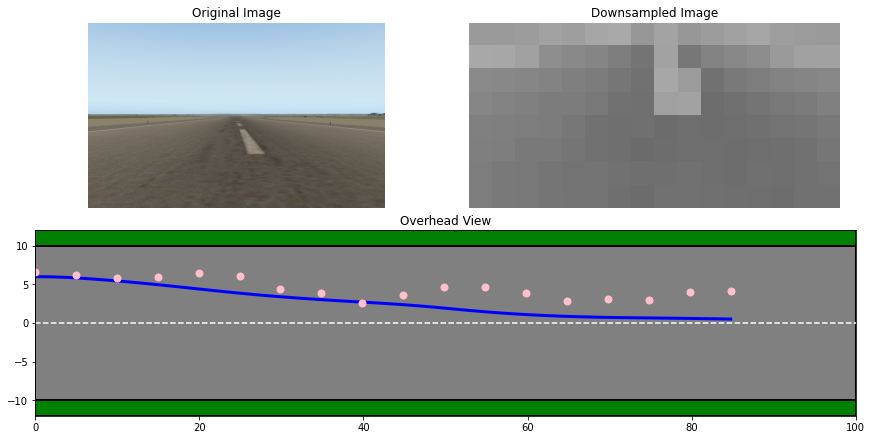

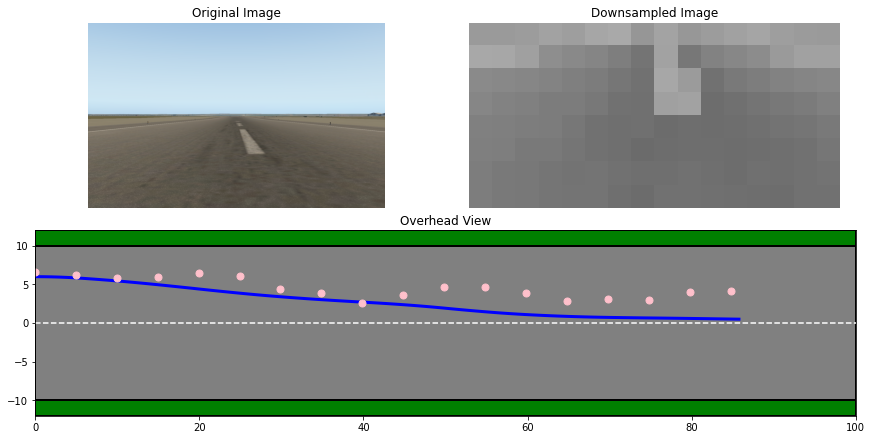

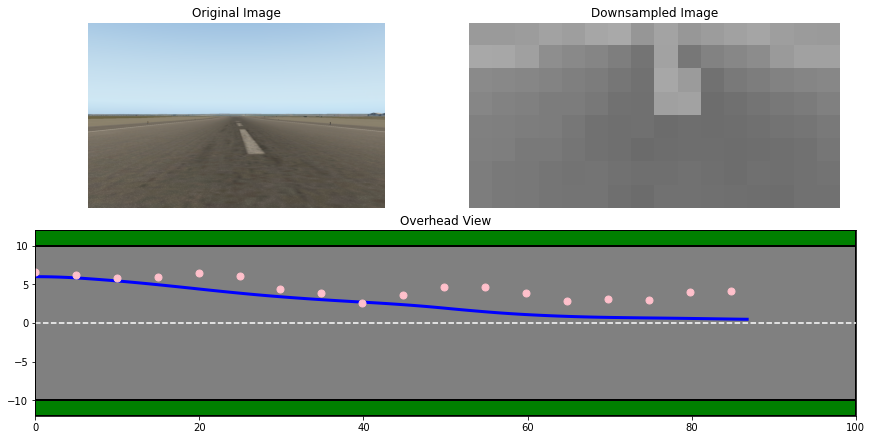

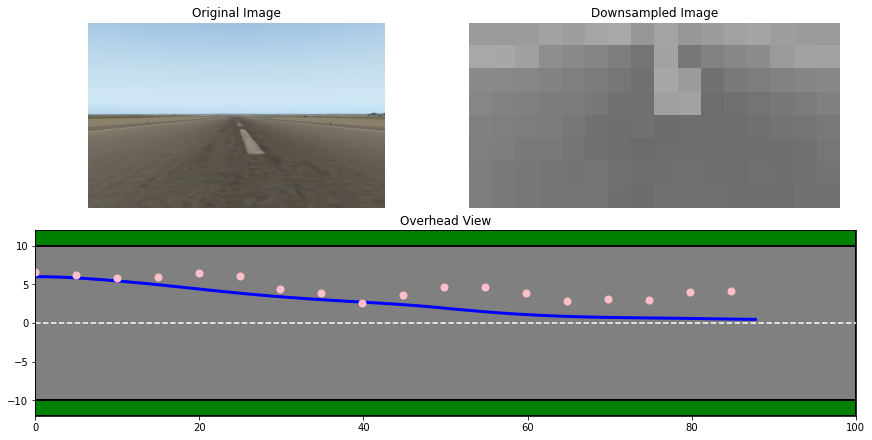

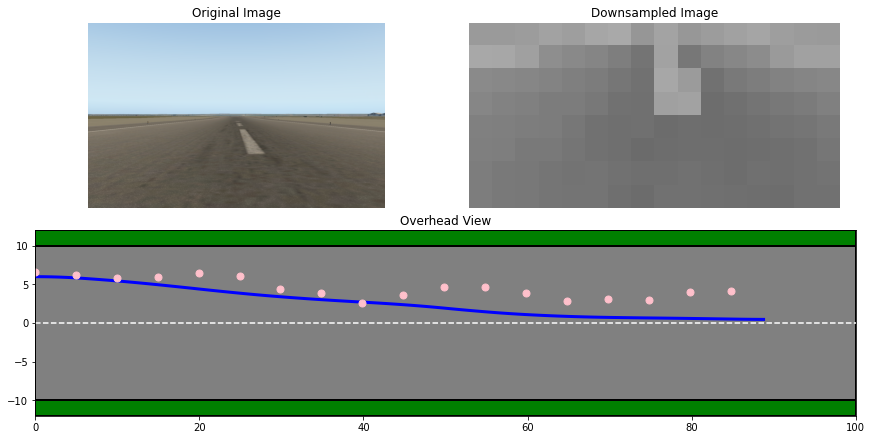

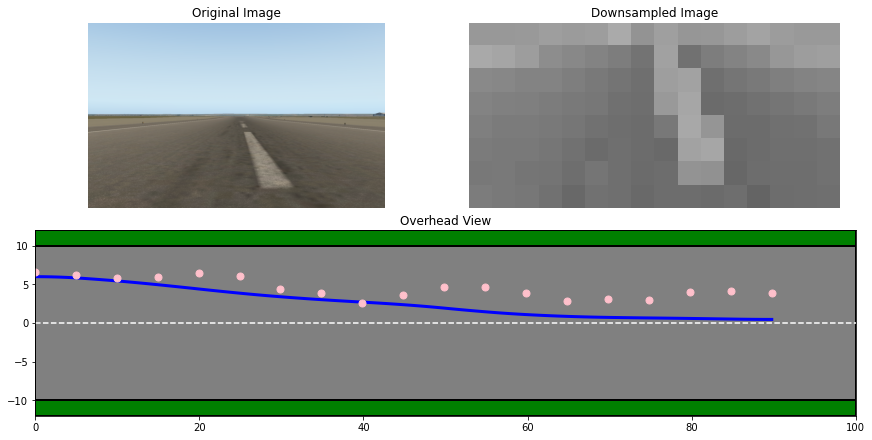

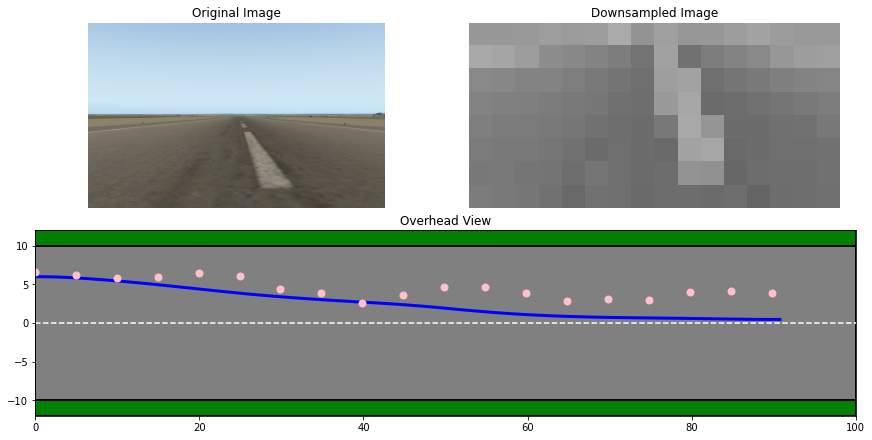

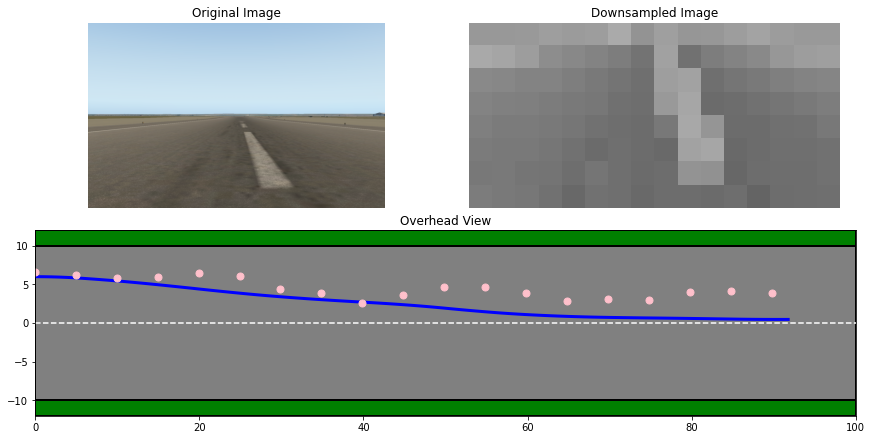

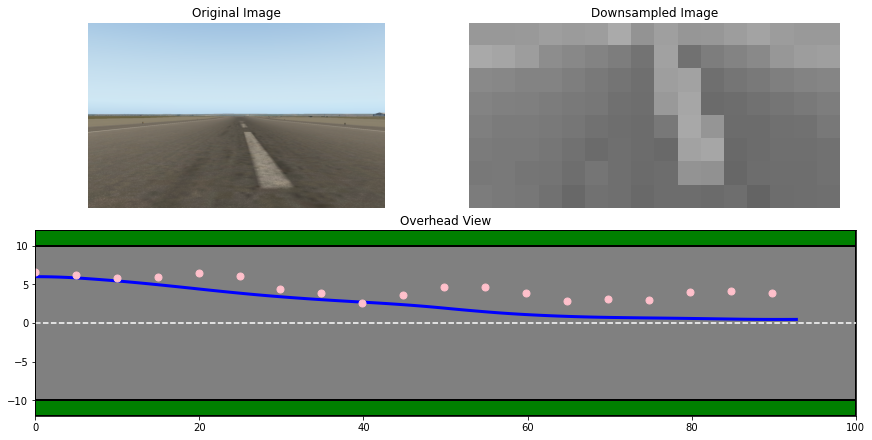

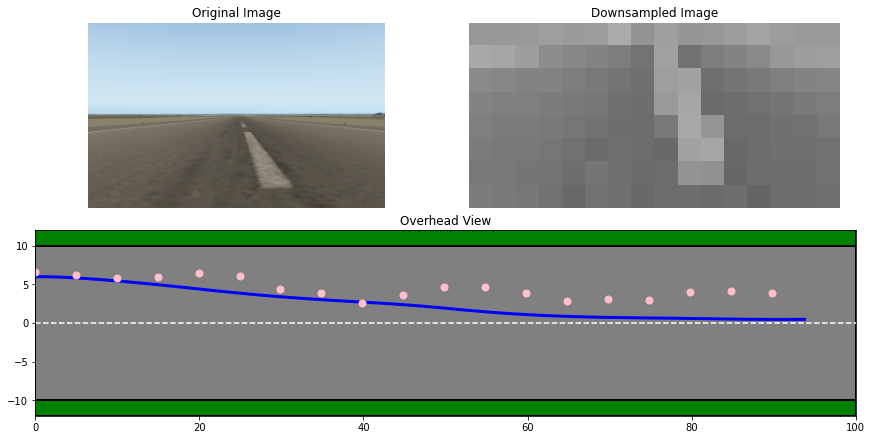

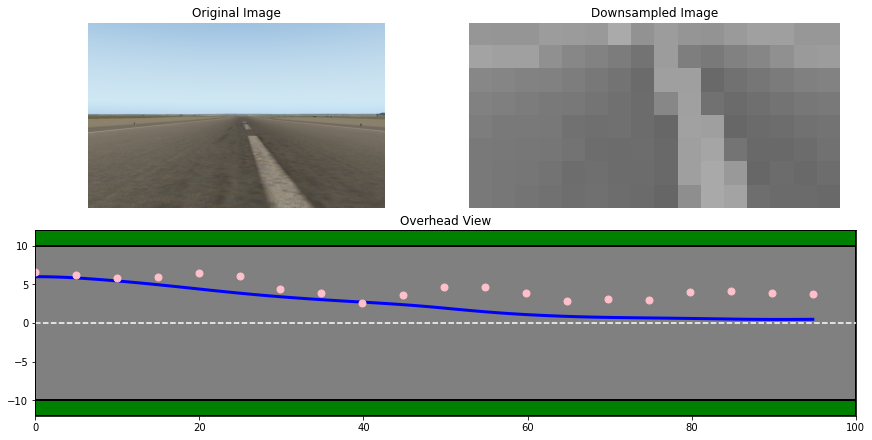

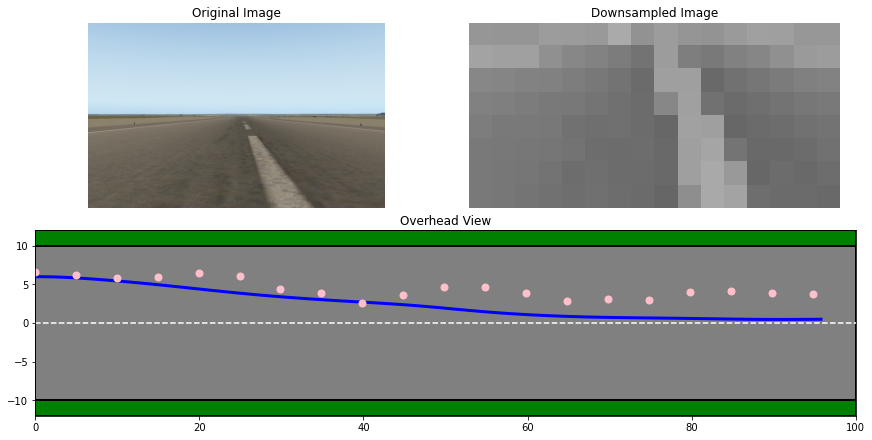

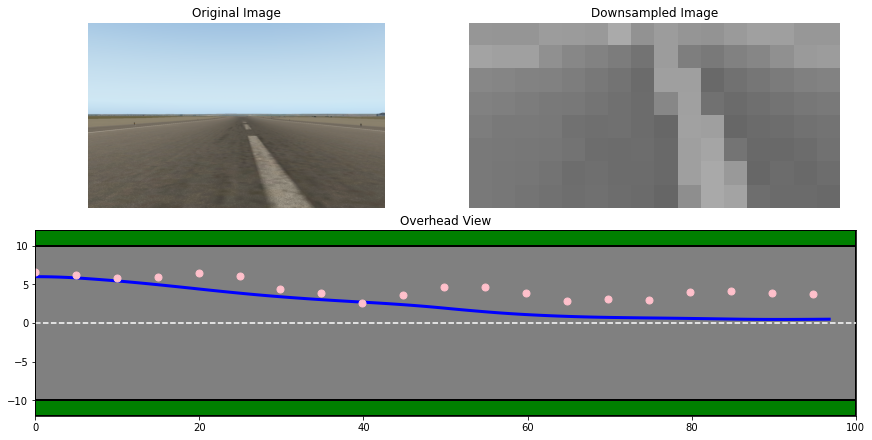

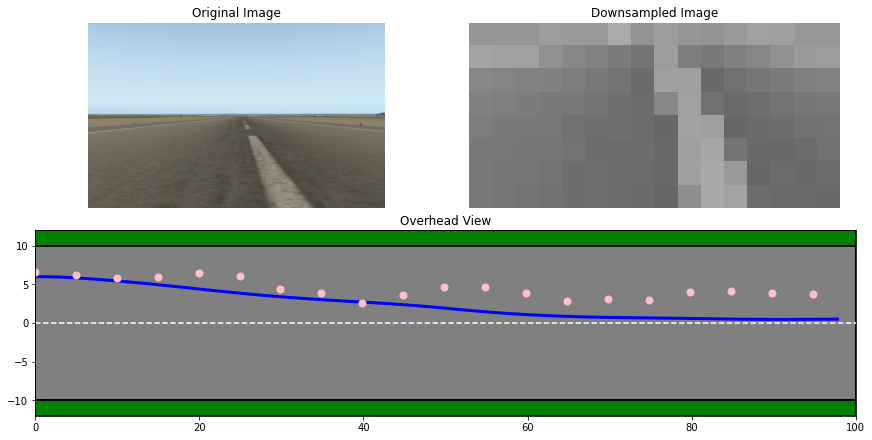

In [55]:
filename = 'picture.gif'  # Change if you want a different filename
create_gif(filename, sss, img_dss, dtps[0::4], ctes[0::4], cte_preds)

Click on the new gif file on the menu on the left and check it out!

### Run many simulations

Now that we have confirmed that our controller is working as intended for one scenario, let's test out some other scenarios. It is important that we make sure our controller will work in many different scenarios. To test this, your next task is to write some code to find the trajectory of the aircraft from a number of starting crosstrack errors by filling in the code cells below.

First, let's initialize some lists to store our outputs:

In [41]:
cte_histories = []
he_histories = []
dtp_histories = []

Next, let's call our simulation function from a number of ctes and append the resuts to our lists:

In [42]:
start_ctes = [-8.0, -6.0, -4.0, -2.0, 0.0, 2.0, 4.0, 6.0, 8.0]

for start_cte in start_ctes:
    # STUDENT CODE START
    # Simulate the trajectory and get the results
    cte_history, he_history, dtp_history, _, _, _, _ = simulate_controller(client, start_cte, 0.0, START_DTP, getState, getControl, taxinet)
    # Append to the lists
    cte_histories.append(cte_history)
    he_histories.append(he_history)
    dtp_histories.append(dtp_history)
    # STUDENT CODE END

1/1 [==============================] - 0s 36ms/step


Finally, let's plot the results! Our goal is to generate a plot similar to the one above for the single trajectory but with all of the trajectories we tested on it. You can use similar code to the plotting code used for the single trajectory. For this case, instead of adding a single trajectory, you will want to loop through the histories and add each trajectory to the plot.

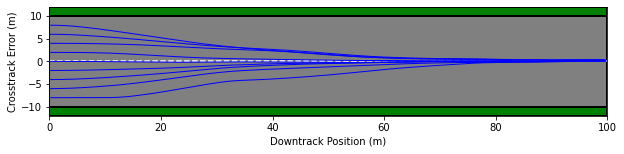

In [43]:
# Get the plot of the road
fig, ax = plot_road()
# Plot the trajectory on the road
for dtp_history, cte_history in zip(dtp_histories, cte_histories):
    ax.plot(dtp_history - START_DTP, cte_history, 'b', linewidth=1)
# Add axis labels
ax.set_xlabel('Downtrack Position (m)')
ax.set_ylabel('Crosstrack Error (m)')
# Display the plot
plt.show()